In [1]:
import os
os.environ['OMP_NUM_THREADS']= '1'
os.environ['MKL_NUM_THREADS'] = '1'
os.environ['OPENBLAS_NUM_THREADS'] = '1'

import time
import numpy as np
from numpy.lib.recfunctions import append_fields,rename_fields
import fitsio as fio
import h5py
# import healpy as hp
import treecorr
import matplotlib
import matplotlib.pyplot as plt
import glob
import gc
import emcee
import corner
from matplotlib import gridspec

from multiprocessing import Pool
# from ray.util.multiprocessing import Pool
from itertools import product

# from astropy.coordinates import SkyCoord
# from astropy import units as u

from pandas import value_counts
from scipy import interpolate,stats
import pyccl as ccl

from cosmo2corr import *
# from mytools import pix_gal, in_mask, jk_numbers, assign_jk, chi

prop_cycle = plt.rcParams['axes.prop_cycle']
colorarray = prop_cycle.by_key()['color']

ell = np.logspace(np.log10(1),np.log10(50000),5000)
theta = np.logspace(np.log10(0.1),np.log10(300),1000) # unit arcmin
# ell = np.linspace(2,10000,5000)
# theta = np.linspace(0.5,300,5000) # unit arcmin

H0,ombh2,omch2,mnu,omk,tau,ns,r,As,Om,sigma8,AIA = load_cosmo(data='KiDS1000_COSEBI_MAP')
# H0,ombh2,omch2,mnu,omk,tau,ns,r,As,Om,sigma8,AIA = load_cosmo(data='Planck')
cosmo = ccl.Cosmology(Omega_c=omch2/(H0/100.)**2, Omega_b=ombh2/(H0/100.)**2, h=H0/100., n_s=ns, sigma8=sigma8,
                          transfer_function='boltzmann_camb', matter_power_spectrum='halofit')
ccl.growth_factor(cosmo,0.5)

0.6343481409005152

In [2]:
plt.rcParams["errorbar.capsize"]

0.0

mean-z = 0.24054292777040875


/home/ji/Research/anaconda3/envs/env1/lib/python3.9/site-packages/pyccl/tracers.py:110: CCLWarning: The number of samples in the n(z) (200) is smaller than the number of samples in the lensing kernel (256). Consider disabling spline integration for the lensing kernel by setting pyccl.gsl_params.LENSING_KERNEL_SPLINE_INTEGRATION = False
  warnings.warn(


BGS_ANY DECaLS S/N = [9.13351252 5.77140917]
[ 4.20419676 51.08668325] [1.17240602 1.17555954] [0.1283631  0.20368674]
mean-z = 0.23982265020298651
BGS_ANY KiDS S/N = [10.2469649   3.86810214]
[ 4.19952639 51.41947095] [0.90115014 1.13780835] [0.08794313 0.29415158]
mean-z = 0.2384289455830612
BGS_ANY HSC S/N = [16.07292815  4.31817226]
[ 4.19951639 50.23443493] [1.15321643 1.31545384] [0.07174899 0.30463209]


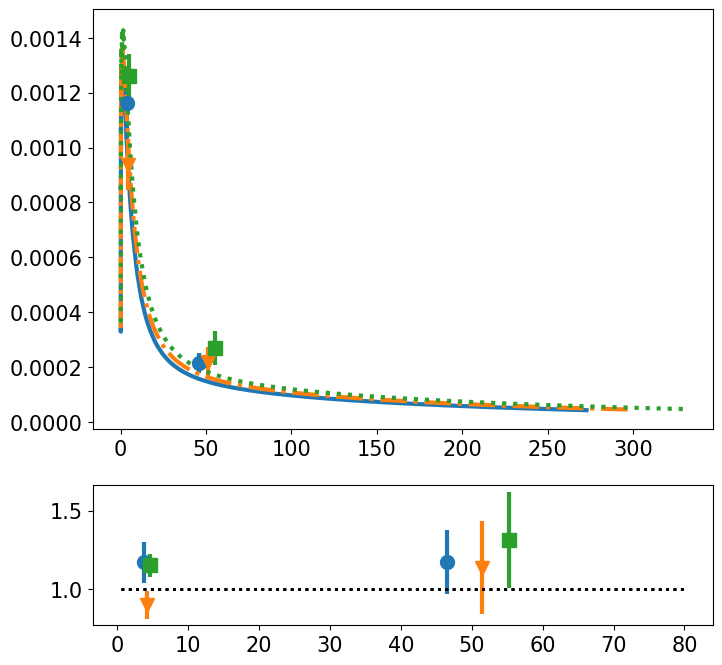

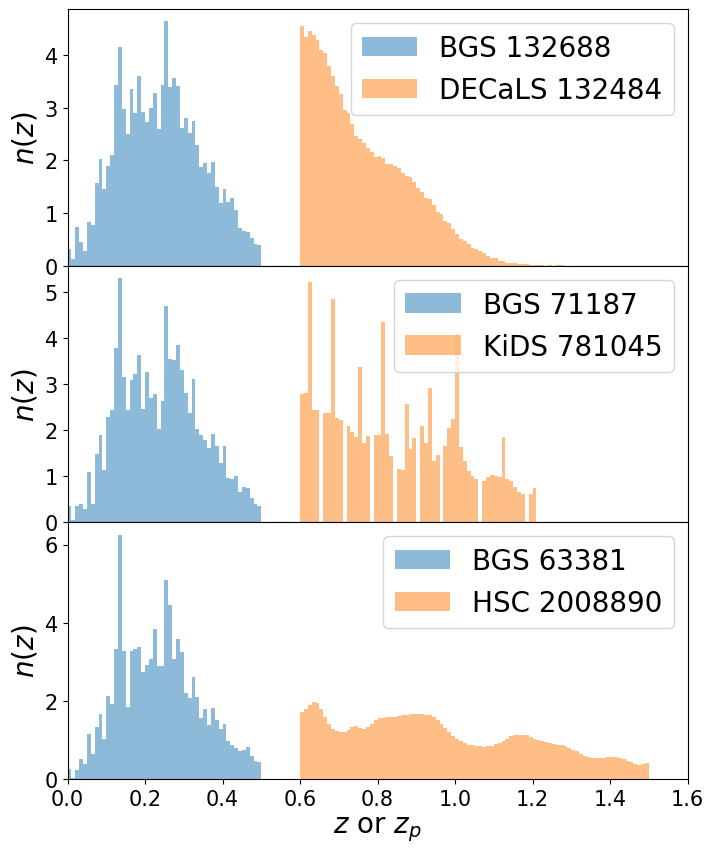

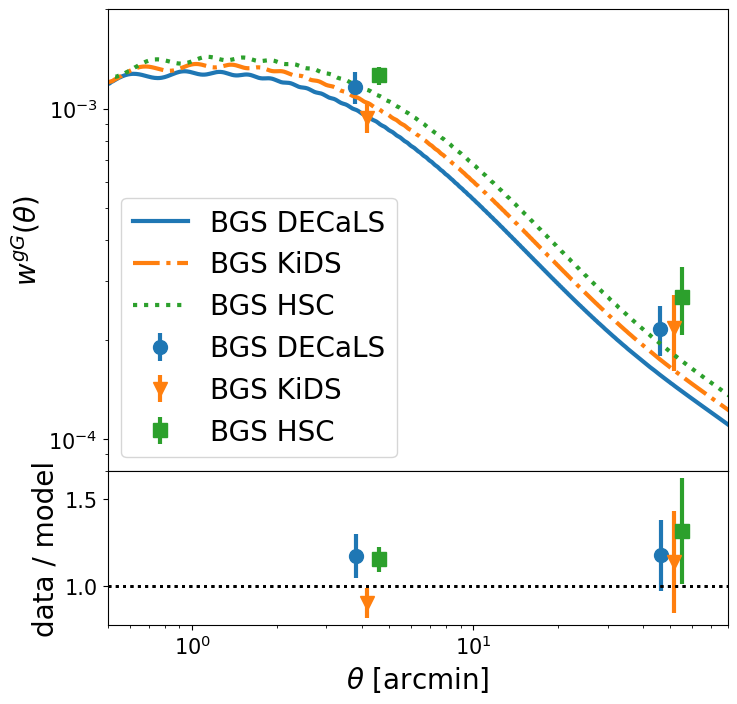

In [3]:
plt.rcParams.update({'font.size': 15})

zrange = np.linspace(0,2,201)
zarr = (zrange[1:]+zrange[:-1])/2
# print(zarr)

def get_nz_file(filename,field):
    f = fio.FITS(filename)
    Njk = len(f)
    nz_hist = np.zeros_like(zarr)
    for i in range(1,Njk):
        f = fio.FITS(filename)[i].read()
        nz_hist += np.histogram(f[field],bins=zrange)[0]
        
    return nz_hist

''' shared quantities for plots '''
Etype = ['shear','kids','hsc']
Ez = ['zp_mean','z_phot','z_phot']
Elabel = ['DECaLS','KiDS','HSC']
dotfmt = ['o','v','s']
linefmt = ['-','-.',':']

''' --- BGS --- '''
Dtype = 'BGS_ANY'
zD_range = [0,0.5]
zE_range = [0.6,1.5]
bD = 1.34
use_mag = False
corr_y_lim = [8e-5,2e-3]

# ''' --- LRG --- '''
# Dtype = 'LRG'
# zD_range = [0,0.6]
# zE_range = [0.7,1.5]
# bD = 1.7
# use_mag = False
# corr_y_lim = [6e-5,3e-3]

''' --- ELG --- '''
# Dtype = 'ELG'
# zD_range = [0,0.7]
# zE_range = [0.8,1.5]
# bD = 0.84
# use_mag = False
# corr_y_lim = [2e-5,1e-3]

''' --- ELG magnification --- '''
# Dtype = 'ELG'
# zD_range = [1,1.7]
# zE_range = [0.4,0.7]
# use_mag = True
# corr_y_lim = [3e-7,3e-4]

fig1 = plt.figure('nz',figsize=(8,10))
fig2 = plt.figure('w',figsize=(8,8))
gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1])
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])

for i in range(3):
    filename = '../data/jk20_'+Etype[i]+'/'+Dtype+'Alltiles_clustering.dat.fits'
    nz_spec = get_nz_file(filename,'Z')
    slt = (zD_range[0]>zarr)|(zarr>zD_range[1])
    nz_spec[slt] = 0
    sumD = np.sum(nz_spec)
    normD = sumD*(zarr[1]-zarr[0])
    nz_spec /= normD
    
    filename = '../data/jk20_'+Etype[i]+'/'+Etype[i]+'_in_footprint.fits'
    nz_phot = get_nz_file(filename,Ez[i])
    slt = (zE_range[0]>zarr)|(zarr>zE_range[1])
    nz_phot[slt] = 0
    sumE = np.sum(nz_phot)
    normE = sumE*(zarr[1]-zarr[0])
    nz_phot /= normE
    
    plt.figure(fig1)
    plt.subplot(3,1,i+1)
    plt.bar(zarr,nz_spec,width=zarr[1]-zarr[0],alpha=0.5,label=Dtype[:3]+' '+str(int(sumD)))
    print('mean-z =',np.average(zarr,weights=nz_spec))
    plt.bar(zarr,nz_phot,width=zarr[1]-zarr[0],alpha=0.5,label=Elabel[i]+' '+str(int(sumE)))
    plt.ylabel(r'$n(z)$',fontsize=20)
    plt.legend(fontsize=20,loc='upper right')
    plt.xlim([0,1.6])
    if i<2:
        plt.xticks([])
        
    if use_mag:
        tracer_K = ccl.WeakLensingTracer(cosmo,dndz=(zarr,nz_spec)) # K
        tracer_G = ccl.WeakLensingTracer(cosmo,dndz=(zarr,nz_phot)) # G
        CGG = ccl.angular_cl(cosmo, tracer_K, tracer_G, ell) # C^{KG}
        wKG = ccl.correlation(cosmo, ell, CGG, theta/60., type='NG', method='FFTLog')
        
        str_zrange = str(zD_range[0])+'-'+str(zD_range[1])+'_'+str(zE_range[0])+'-'+str(zE_range[1])
        filename = '../data/jk20_'+Etype[i]+'/gG_'+Dtype+str_zrange+'/corr_gG_'+Dtype+str_zrange+'.npz'
        f = np.load(filename)
        
        filename = '../data/jk20_'+Etype[i]+'/gG_'+Dtype+str_zrange+'_rN20/corr_gG_'+Dtype+str_zrange+'.npz'
        ft = np.load(filename)
        t_EDw = np.average(ft['sum_EDw'],axis=0)
        t_wKG = ccl.correlation(cosmo, ell, CGG, ft['r']/60., type='NG', method='FFTLog')
#         print(t_wgG)
        t_x = np.array([ np.average(ft['r'][:10],weights=t_EDw[:10]), np.average(ft['r'][-10:],weights=t_EDw[-10:]) ])
        t_y = np.array([ np.average(t_wKG[:10],weights=t_EDw[:10]), np.average(t_wKG[-10:],weights=t_EDw[-10:]) ])

        plt.figure(fig2)
        lbl = Dtype[:3]+' '+Elabel[i]
        ax0.errorbar(f['r']*1.1**(i-1),f['gamma_t'],f['gamma_t_err'],fmt=dotfmt[i],color=colorarray[i],label=lbl,linewidth=3,markersize=10)
        ax0.plot(theta*1.1**(i-1),wKG,linefmt[i],color=colorarray[i],label=lbl,linewidth=3)
        print(Dtype,Elabel[i],'S/N =',f['gamma_t']/f['gamma_t_err'])
        
        ax1.errorbar(f['r']*1.1**(i-1),f['gamma_t']/t_y,f['gamma_t_err']/t_y,fmt=dotfmt[i],color=colorarray[i],label=lbl,linewidth=3,markersize=10)
        ax1.plot([0.5,80],[1,1],'k:',linewidth=2)
        
    else:
        aarr = 1 / (1+zarr)
        Darr = ccl.growth_factor(cosmo,aarr)
#         Davg = np.average(Darr,weights=nz_spec)
#         b_g = bD / Davg * np.ones_like(zarr)
        b_g = bD / Darr

        tracer_g = ccl.NumberCountsTracer(cosmo,has_rsd=False,dndz=(zarr,nz_spec),bias=(zarr,b_g)) # g
        tracer_G = ccl.WeakLensingTracer(cosmo,dndz=(zarr,nz_phot)) # G
        CgG = ccl.angular_cl(cosmo, tracer_g, tracer_G, ell) # C^{gG}
        wgG = ccl.correlation(cosmo, ell, CgG, theta/60., type='NG', method='FFTLog')

        str_zrange = str(zD_range[0])+'-'+str(zD_range[1])+'_'+str(zE_range[0])+'-'+str(zE_range[1])
        filename = '../data/jk20_'+Etype[i]+'/gG_'+Dtype+str_zrange+'/corr_gG_'+Dtype+str_zrange+'.npz'
        f = np.load(filename)
        
        filename = '../data/jk20_'+Etype[i]+'/gG_'+Dtype+str_zrange+'_rN20/corr_gG_'+Dtype+str_zrange+'.npz'
        ft = np.load(filename)
        t_EDw = np.average(ft['sum_EDw'],axis=0)
        t_wgG = ccl.correlation(cosmo, ell, CgG, ft['r']/60., type='NG', method='FFTLog')
#         print(t_wgG)
        t_x = np.array([ np.average(ft['r'][:10],weights=t_EDw[:10]), np.average(ft['r'][-10:],weights=t_EDw[-10:]) ])
        t_y = np.array([ np.average(t_wgG[:10],weights=t_EDw[:10]), np.average(t_wgG[-10:],weights=t_EDw[-10:]) ])

        plt.figure(fig2)
        lbl = Dtype[:3]+' '+Elabel[i]
        ax0.errorbar(f['r']*(1+(i-1)*0.1),f['gamma_t'],f['gamma_t_err'],fmt=dotfmt[i],color=colorarray[i],label=lbl,linewidth=3,markersize=10)
        ax0.plot(theta*1.1**(i-1),wgG,linefmt[i],color=colorarray[i],label=lbl,linewidth=3)
#         plt.scatter(t_x,t_y,color=colorarray[i],marker='x',linewidth=5)
        print(Dtype,Elabel[i],'S/N =',f['gamma_t']/f['gamma_t_err'])
    
        ax1.errorbar(f['r']*1.1**(i-1),f['gamma_t']/t_y,f['gamma_t_err']/t_y,fmt=dotfmt[i],color=colorarray[i],label=lbl,linewidth=3,markersize=10)
        ax1.plot([0.5,80],[1,1],'k:',linewidth=2)
        
        print(f['r'],f['gamma_t']/t_y,f['gamma_t_err']/t_y)
    
plt.figure(fig1)
plt.subplots_adjust(wspace=0, hspace=0)
plt.xlabel(r'$z$ or $z_p$',fontsize=20)
# plt.xticks(np.linspace(0,1.6,9),np.linspace(0,1.6,9),fontsize=15)
# plt.yticks(np.linspace(0,6,7),np.linspace(0,6,7),fontsize=15)
# plt.xlim([0,1.6])
if use_mag:
    filename = '../figure/nz_'+Dtype+'_mag.png'
else:
    filename = '../figure/nz_'+Dtype+'.png'
plt.savefig(filename,bbox_inches='tight',dpi=300)
plt.show()

plt.figure(fig2)
ax0.plot(theta,np.zeros_like(theta),'k:')
ax0.set_xlim([0.5,80])
ax0.set_ylim(corr_y_lim)
ax0.semilogx()
ax0.semilogy()
# ax0.set_xlabel(r'$\theta$ [arcmin]',fontsize=20)
if use_mag:
    ax0.set_ylabel(r'$w^{\kappa G}(\theta)$',fontsize=20)
else:
    ax0.set_ylabel(r'$w^{gG}(\theta)$',fontsize=20)
ax0.legend(fontsize=20,loc='lower left')
if use_mag:
    filename = '../figure/wgG_'+Dtype+'_mag.png'
else:
    filename = '../figure/wgG_'+Dtype+'.png'
    
ax1.set_xlim([0.5,80])
ax1.semilogx()
ax1.set_xlabel(r'$\theta$ [arcmin]',fontsize=20)
ax1.set_ylabel('data / model',fontsize=20)
plt.subplots_adjust(wspace=0, hspace=0)
plt.savefig(filename,bbox_inches='tight',dpi=300)
plt.show()


ELG DECaLS S/N = [ 0.9734259  -0.99789072]
ELG KiDS S/N = [ 0.97253547 -0.26684707]
ELG HSC S/N = [-0.29792764 -2.41289346]
ELG DECaLS S/N = [2.19367947 0.33089752]
ELG KiDS S/N = [ 1.23454836 -0.33208163]
ELG HSC S/N = [ 2.75562285 -0.28096055]


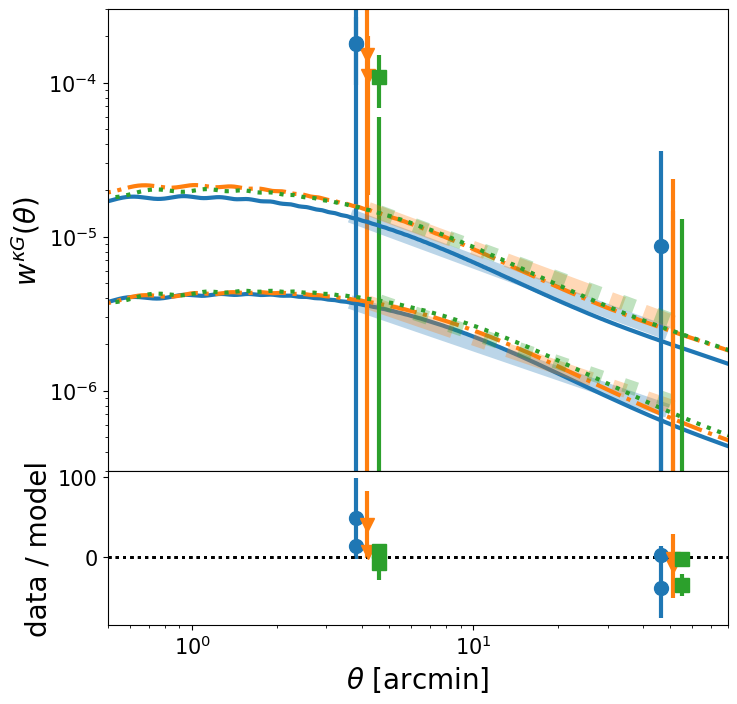

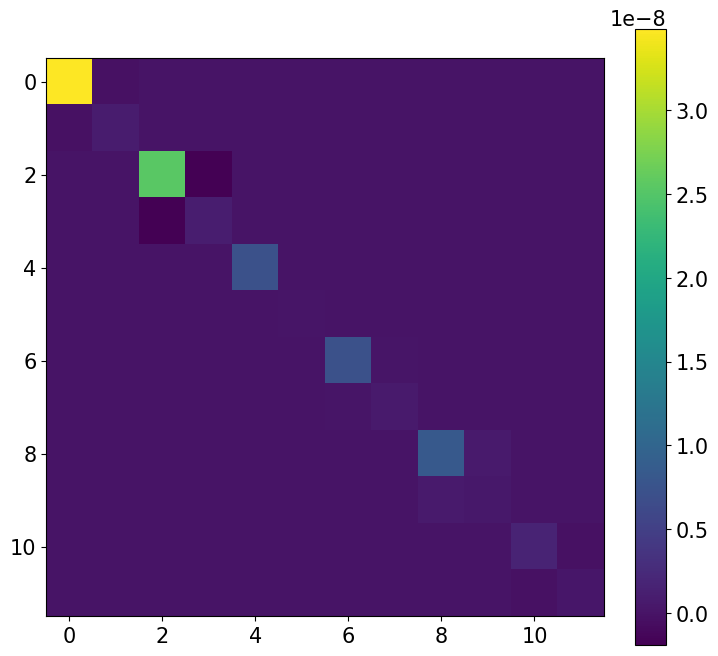

In [4]:
'''
Check overall fit for DECaLS+KiDS+HSC, with large+small scale, with low+high z
'''

''' --- ELG magnification --- '''
Dtype = 'ELG'
zD_range = [1,1.7]
zE_range_list = [[0,0.4],[0.4,0.7]]
use_mag = True
corr_y_lim = [3e-7,3e-4]

m_data = np.zeros(12)
m_cov = np.zeros((12,12))
m_model = np.zeros_like(m_data)

fig2 = plt.figure('w',figsize=(8,8))
gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1])
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])

for j,zE_range in enumerate(zE_range_list):
    for i in range(3):
        filename = '../data/jk20_'+Etype[i]+'/'+Dtype+'Alltiles_clustering.dat.fits'
        nz_spec = get_nz_file(filename,'Z')
        slt = (zD_range[0]>zarr)|(zarr>zD_range[1])
        nz_spec[slt] = 0
        sumD = np.sum(nz_spec)
        normD = sumD*(zarr[1]-zarr[0])
        nz_spec /= normD

        filename = '../data/jk20_'+Etype[i]+'/'+Etype[i]+'_in_footprint.fits'
        nz_phot = get_nz_file(filename,Ez[i])
        slt = (zE_range[0]>zarr)|(zarr>zE_range[1])
        nz_phot[slt] = 0
        sumE = np.sum(nz_phot)
        normE = sumE*(zarr[1]-zarr[0])
        nz_phot /= normE

        if use_mag:
            tracer_K = ccl.WeakLensingTracer(cosmo,dndz=(zarr,nz_spec)) # K
            tracer_G = ccl.WeakLensingTracer(cosmo,dndz=(zarr,nz_phot)) # G
            CGG = ccl.angular_cl(cosmo, tracer_K, tracer_G, ell) # C^{KG}
            wKG = ccl.correlation(cosmo, ell, CGG, theta/60., type='NG', method='FFTLog')

            str_zrange = str(zD_range[0])+'-'+str(zD_range[1])+'_'+str(zE_range[0])+'-'+str(zE_range[1])
            filename = '../data/jk20_'+Etype[i]+'/gG_'+Dtype+str_zrange+'/corr_gG_'+Dtype+str_zrange+'.npz'
            f = np.load(filename)

            filename = '../data/jk20_'+Etype[i]+'/gG_'+Dtype+str_zrange+'_rN20/corr_gG_'+Dtype+str_zrange+'.npz'
            ft = np.load(filename)
            t_EDw = np.average(ft['sum_EDw'],axis=0)
            t_wKG = ccl.correlation(cosmo, ell, CGG, ft['r']/60., type='NG', method='FFTLog')
    #         print(t_wgG)
            t_x = np.array([ np.average(ft['r'][:10],weights=t_EDw[:10]), np.average(ft['r'][-10:],weights=t_EDw[-10:]) ])
            t_y = np.array([ np.average(t_wKG[:10],weights=t_EDw[:10]), np.average(t_wKG[-10:],weights=t_EDw[-10:]) ])

            plt.figure(fig2)
            lbl = Dtype[:3]+' '+Elabel[i]
#             ax0.errorbar(f['r']*1.1**(i-1),f['gamma_t'],f['gamma_t_err'],fmt=dotfmt[i],color=colorarray[i],label=lbl,linewidth=3,markersize=10)
            ax0.plot(theta*1.1**(i-1),wKG,linefmt[i],color=colorarray[i],label=lbl,linewidth=3)
            print(Dtype,Elabel[i],'S/N =',f['gamma_t']/f['gamma_t_err'])

            ax1.errorbar(f['r']*1.1**(i-1),f['gamma_t']/t_y,f['gamma_t_err']/t_y,fmt=dotfmt[i],color=colorarray[i],label=lbl,linewidth=3,markersize=10)
            ax1.plot([0.5,80],[1,1],'k:',linewidth=2)
            
            tmp = j*6+i*2
            m_data[tmp:tmp+2] = f['gamma_t']
            m_model[tmp:tmp+2] = t_y
            m_cov[tmp:tmp+2,tmp:tmp+2] = np.cov(f['jk_gamma_t'].T)*(20-1)
            
            plt.figure(fig2)
            lbl = Dtype[:3]+' '+Elabel[i]
            ax0.errorbar(f['r']*1.1**(i-1),m_data[tmp:tmp+2],np.sqrt(np.diag(m_cov[tmp:tmp+2,tmp:tmp+2])),fmt=dotfmt[i],color=colorarray[i],label=lbl,linewidth=3,markersize=10)
            ax0.plot(t_x*1.1**(i-1),m_model[tmp:tmp+2],linefmt[i],color=colorarray[i],label=lbl,linewidth=10,alpha=0.3)

plt.figure(fig2)
ax0.plot(theta,np.zeros_like(theta),'k:')
ax0.set_xlim([0.5,80])
ax0.set_ylim(corr_y_lim)
ax0.semilogx()
ax0.semilogy()
# ax0.set_xlabel(r'$\theta$ [arcmin]',fontsize=20)
if use_mag:
    ax0.set_ylabel(r'$w^{\kappa G}(\theta)$',fontsize=20)
else:
    ax0.set_ylabel(r'$w^{gG}(\theta)$',fontsize=20)
# ax0.legend(fontsize=20,loc='lower left')
if use_mag:
    filename = '../figure/wgG_'+Dtype+'_mag.png'
else:
    filename = '../figure/wgG_'+Dtype+'.png'
    
ax1.set_xlim([0.5,80])
ax1.semilogx()
ax1.set_xlabel(r'$\theta$ [arcmin]',fontsize=20)
ax1.set_ylabel('data / model',fontsize=20)
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

plt.figure(figsize=(8,8))
img = plt.imshow(m_cov)
plt.rcParams['font.size'] = 15
plt.colorbar(img,fraction=0.05,pad=0.05)
plt.rcParams['font.size'] = 10
# field_names = ['e1','e2','magz','r-z','z-g','log10SNg','log10SNr','log10SNz','r_1/2','type','psfsize_g','psfsize_r','psfsize_z','psfdepth_g','psfdepth_r','psfdepth_z','w8','g1','g2']
# plt.xticks(np.arange(len(field_names)),field_names,rotation=70,fontsize=12)
# plt.yticks(np.arange(len(field_names)),field_names,rotation=20,fontsize=12)
plt.show()

burn-in steps = 100, finished


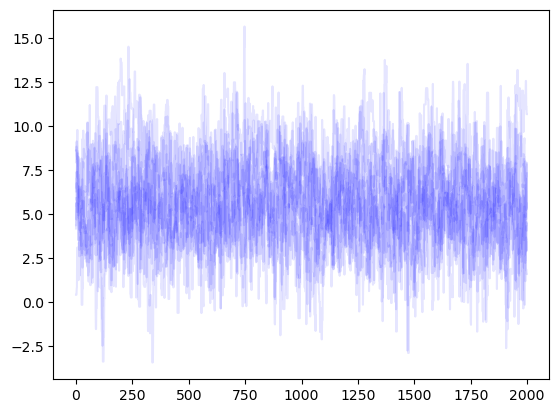

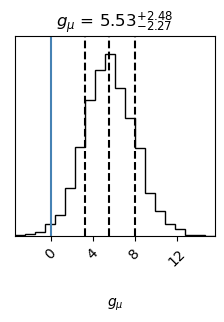

gmu =  [5.59513635]
\Delta gmu = [2.40043954]
chi^2 of best-fit =, 1.1369287012643272
chi^2 with respect to 0 = 6.563872268457129
\Delta\chi^2 = 5.426943567192803


In [5]:
gmu_prior = [-20,20]

def lnprior_gmu(gmu):
    if (gmu_prior[0]<gmu and gmu<gmu_prior[1]):
        return 0.0
    return -np.inf

def lnL_gmu(gmu,m_data,m_model,m_cov,cut=[0],Hartlap_correction=False): # my likelihood implementation directly from data
    lp = lnprior_gmu(gmu)
    if not np.isfinite(lp):
        return -np.inf

    vec = m_data[cut] - gmu*m_model[cut]
    Cinv = np.linalg.pinv(m_cov[cut,:][:,cut])
    if Hartlap_correction:
        Cinv *= ( 20 - 2 - 2 ) / (20-1)

    return lp - 0.5*np.dot( vec, np.dot(Cinv,vec) )

def fit_gmu(cut=[0],Hartlap_correction=False): # fit magnification g_mu
    samplelist = ['BGS_ANY0-0.5_0.9-1.5','BGS_ANY0-0.5_0.6-0.9']
    ''' --------- MCMC parameters '''
    nwalkers = 10
    ndim = 1
    nsteps = 2000

    p0 = np.array([[np.random.rand() for i in range(ndim)] for j in range(nwalkers)])
    for i in range(ndim):
        p0[:,i] = gmu_prior[0] + p0[:,i] * (gmu_prior[1]-gmu_prior[0])

    with Pool(processes=nwalkers) as pool:
    # with MPIPool() as pool:
    #     if not pool.is_master():
    #         pool.wait()
    #         sys.exit(0)

        sampler = emcee.EnsembleSampler(nwalkers, ndim, lnL_gmu, args=(m_data,m_model,m_cov,cut,Hartlap_correction),pool=pool)
        pos, prob, state = sampler.run_mcmc(p0, 100)
        sampler.reset()
        print('burn-in steps = 100, finished')
        sampler.run_mcmc(pos, nsteps)

    plt.figure()
    for i in range(ndim):
        plt.subplot(ndim,1,i+1)
        for j in range(nwalkers):
            plt.plot(sampler.chain[j, :, i].reshape(nsteps),color='b',alpha=0.1)
    plt.show()

    stepcut = 0
    samples = sampler.chain[:,stepcut:,:].reshape((-1, ndim))

    lbl = [r'$g_\mu$']
    tr_val = [0.]
    fig = corner.corner(samples,labels=lbl,
                      truths=tr_val, quantiles=[0.16, 0.5, 0.84], show_titles=True, levels=(0.68,0.95,), plot_datapoints=False)
    plt.show()

    tmp = np.mean(samples,axis=0)
    print('gmu = ', tmp)
    tmp = np.std(samples,axis=0)
    print('\Delta gmu =',tmp)
    tmp1 = -2*lnL_gmu(np.mean(samples,axis=0),m_data,m_model,m_cov,cut=cut,Hartlap_correction=True)
    print('chi^2 of best-fit =,',tmp1)
    tmp2 = -2*lnL_gmu(np.mean(samples,axis=0),m_data,np.zeros_like(m_data),m_cov,cut=cut,Hartlap_correction=True)
    print('chi^2 with respect to 0 =',tmp2)
    print('\Delta\chi^2 =',tmp2-tmp1)
    
    return samples

gmu_samples_H = fit_gmu(cut=np.array([10,11]),Hartlap_correction=True)


In [6]:
print('chi^2 of best-fit =',-2*lnL_gmu(np.mean(gmu_samples_H,axis=0),m_data,m_model,m_cov,Hartlap_correction=True))
print('chi^2 with respect to 0 =',-2*lnL_gmu(np.mean(gmu_samples_H,axis=0),m_data,np.zeros_like(m_data),m_cov,Hartlap_correction=True))
print(np.sqrt(19.2-12.6))

chi^2 of best-fit = 0.5937636960999602
chi^2 with respect to 0 = 0.7580463785035192
2.569046515733026


In [7]:
m_data/np.sqrt(np.diag(m_cov))

array([ 0.9487782 , -0.97262356,  0.94791032, -0.26009035, -0.29038394,
       -2.35179764,  2.13813427,  0.32251901,  1.2032889 , -0.32367314,
        2.68584892, -0.27384647])

In [8]:
# tmp = np.load('../data/jk20_shear/gG_BGS_ANY0-0.5_0.6-1.5_rN20/corr_gG_BGS_ANY0-0.5_0.6-1.5.npz')
tmp = np.load('../data/jk20_shear/gG_ELG1-1.7_0.4-0.7_rN20/corr_gG_ELG1-1.7_0.4-0.7.npz')
print(tmp['r'])
t_EDw = np.average(tmp['sum_EDw'],axis=0)
print(np.average(tmp['r'][:10],weights=t_EDw[:10]))
print(np.average(tmp['r'][-10:],weights=t_EDw[-10:]))

tmp = np.load('../data/jk20_shear/gG_BGS_ANY0-0.5_0.6-1.5/corr_gG_BGS_ANY0-0.5_0.6-1.5.npz')
print(tmp['r'])

[ 0.57583238  0.74157258  0.95586167  1.23144338  1.58744284  2.04564691
  2.63657532  3.39732891  4.37919142  5.64375434  7.27328308  9.37318211
 12.08048916 15.56720208 20.06083369 25.8497416  33.30811605 42.91115978
 55.27602155 71.18753863]
4.2335097466303555
51.03195565033058
[ 4.20419676 51.08668325]


In [9]:
tmp1 = np.load('../data/jk20_hsc/gG_ELG1-1.7_0.4-0.7/corr_gG_ELG1-1.7_0.4-0.7.npz')
tmp2 = np.load('../data/jk20_hsc/gG_ELG1-1.7_0-0.7/corr_gG_ELG1-1.7_0-0.7.npz')
print(tmp1['gamma_t'])

[ 1.09483696e-04 -4.92769900e-06]


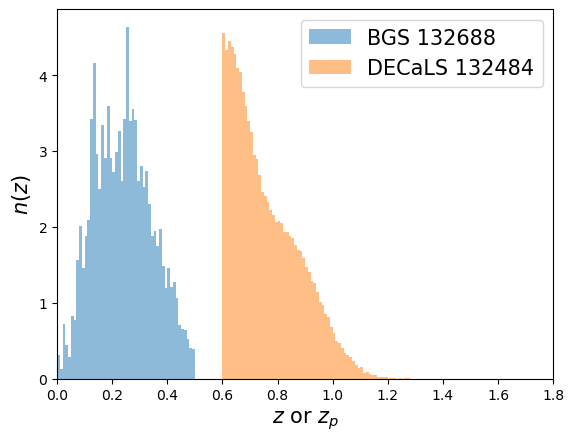

../data/jk50_shear/gG_BGS_ANY0-0.5_0.6-1.5/corr_gG_BGS_ANY0-0.5_0.6-1.5.npz


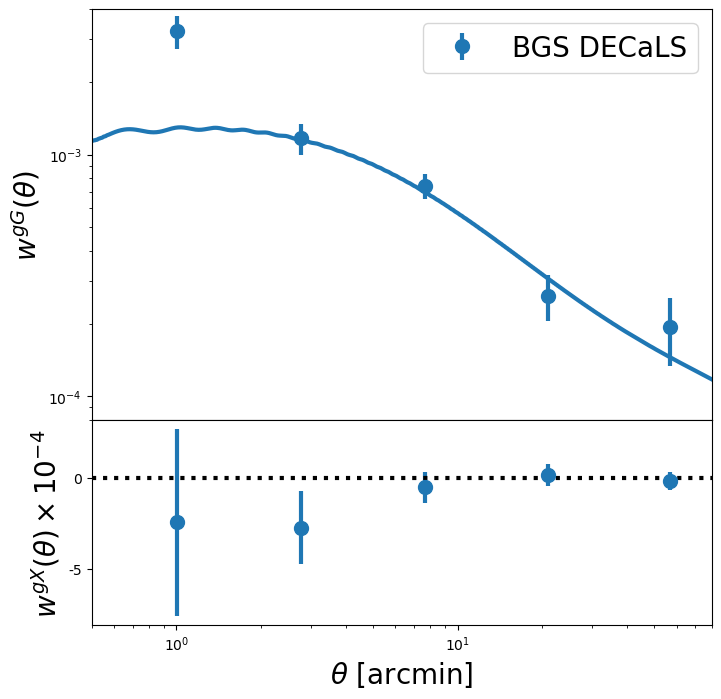

S/N = [6.51629341 6.63122296 8.38836579 4.66624001 3.18559127]


In [10]:
from matplotlib import gridspec

''' --- BGS --- '''
Dtype = 'BGS_ANY'
zD_range = [0,0.5]
Etype = ['shear','kids','hsc']
Ez = ['zp_mean','z_phot','z_phot']
zE_range = [0.6,1.5]
Elabel = ['DECaLS','KiDS','HSC']
bD = 1.34
use_mag = False

# ''' --- LRG --- '''
# Dtype = 'LRG'
# zD_range = [0,0.6]
# Etype = ['shear','kids','hsc']
# Ez = ['zp_mean','z_phot','z_phot']
# zE_range = [0.7,1.5]
# Elabel = ['DECaLS','KiDS','HSC']
# bD = 1.7
# use_mag = False

filename = '../data/jk50_shear/'+Dtype+'Alltiles_clustering.dat.fits'
nz_spec = get_nz_file(filename,'Z')
slt = (zD_range[0]>zarr)|(zarr>zD_range[1])
nz_spec[slt] = 0
sumD = np.sum(nz_spec)
normD = sumD*(zarr[1]-zarr[0])
nz_spec /= normD
    
filename = '../data/jk50_shear/shear_in_footprint.fits'
nz_phot = get_nz_file(filename,'zp_mean')
slt = (zE_range[0]>zarr)|(zarr>zE_range[1])
nz_phot[slt] = 0
sumE = np.sum(nz_phot)
normE = sumE*(zarr[1]-zarr[0])
nz_phot /= normE
    
plt.figure()
plt.bar(zarr,nz_spec,width=zarr[1]-zarr[0],alpha=0.5,label=Dtype[:3]+' '+str(int(sumD)))
plt.bar(zarr,nz_phot,width=zarr[1]-zarr[0],alpha=0.5,label=Elabel[0]+' '+str(int(sumE)))
plt.ylabel(r'$n(z)$',fontsize=15)
plt.legend(fontsize=15)
plt.xlim([0,1.8])
plt.xlabel(r'$z$ or $z_p$',fontsize=15)
plt.show()

aarr = 1 / (1+zarr)
Darr = ccl.growth_factor(cosmo,aarr)
# Davg = np.average(Darr,weights=nz_spec)
# b_g = bD / Davg * np.ones_like(zarr)
b_g = bD / Darr

tracer_g = ccl.NumberCountsTracer(cosmo,has_rsd=False,dndz=(zarr,nz_spec),bias=(zarr,b_g)) # g
tracer_G = ccl.WeakLensingTracer(cosmo,dndz=(zarr,nz_phot)) # G
CgG = ccl.angular_cl(cosmo, tracer_g, tracer_G, ell) # C^{gG}
wgG = ccl.correlation(cosmo, ell, CgG, theta/60., type='NG', method='FFTLog')

str_zrange = str(zD_range[0])+'-'+str(zD_range[1])+'_'+str(zE_range[0])+'-'+str(zE_range[1])
filename = '../data/jk50_shear/gG_'+Dtype+str_zrange+'/corr_gG_'+Dtype+str_zrange+'.npz'
print(filename)
f = np.load(filename)

plt.figure(figsize=(8,8))
gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1])
ax0 = plt.subplot(gs[0])
lbl = Dtype[:3]+' DECaLS'
ax0.errorbar(f['r'],f['gamma_t'],f['gamma_t_err'],fmt='o',color=colorarray[0],label=lbl,linewidth=3,markersize=10)
plt.plot(theta,wgG,color=colorarray[0],linewidth=3)
plt.plot(theta,np.zeros_like(theta),'k:')
plt.xlim([0.5,80])
plt.ylim([8e-5,4e-3])
plt.semilogx()
plt.semilogy()
plt.xlabel(r'$\theta$ [arcmin]',fontsize=20)
plt.ylabel(r'$w^{gG}(\theta)$',fontsize=20)
plt.legend(fontsize=20)

ax1 = plt.subplot(gs[1])
ax1.errorbar(f['r'],f['gamma_x'],f['gamma_x_err'],fmt='o',color=colorarray[0],label=lbl,linewidth=3,markersize=10)
ax1.plot([0.5,80],[0,0],'k:',linewidth=3)
plt.yticks([-5e-4,0],[-5,0])#[r'$-5\times10^{-4}$',r'$0$'])
plt.xlim([0.5,80])
plt.semilogx()
plt.xlabel(r'$\theta$ [arcmin]',fontsize=20)
plt.ylabel(r'$w^{gX}(\theta)\times10^{-4}$',fontsize=20)
plt.subplots_adjust(wspace=0, hspace=0)

filename = '../figure/wgG_BGS_DECaLS.png'
plt.savefig(filename,bbox_inches='tight',dpi=300)
plt.show()
print('S/N =',f['gamma_t']/f['gamma_t_err'])



In [11]:
jkN = 50
print(np.dot(f['gamma_x'],np.dot(np.linalg.inv(np.cov(f['jk_gamma_t'].T)*(jkN-1)),f['gamma_x'])))
print(np.sum((f['gamma_x']/f['gamma_x_err'])**2))

print(np.dot(f['gamma_t'],np.dot(np.linalg.inv(np.cov(f['jk_gamma_t'].T)*(jkN-1)),f['gamma_t'])))

3.0070823740825112
2.717103812307704
179.56622803367736


burn-in steps = 100, finished


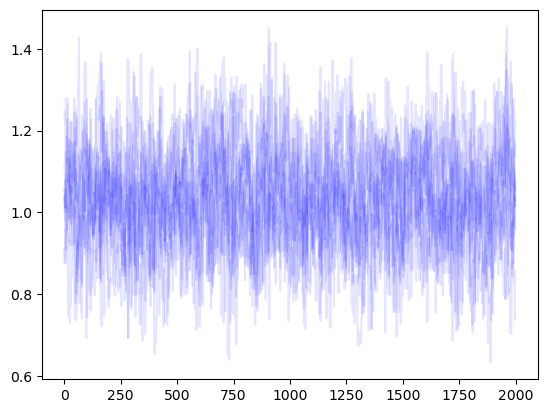

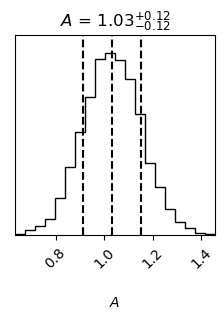

A =  [1.03167512]
\Delta A = [0.11922041]
S/N = [8.65351063]


array([[1.27682729],
       [1.27682729],
       [1.27682729],
       ...,
       [1.15207409],
       [1.16576784],
       [1.16576784]])

In [12]:
A_prior = [0,2]
jkN = 50

def lnprior_A(A):
    if (A_prior[0]<A and A<A_prior[1]):
        return 0.0
    return -np.inf


def lnL_A(A,d,m,Cinv): # my likelihood implementation directly from data
    lp = lnprior_A(A)
    if not np.isfinite(lp):
        return -np.inf

    vec = d - A*m

    return lp - 0.5*np.dot( vec, np.dot(Cinv,vec) )

def fit_A(cut=[-1],Hartlap_correction=False): # fit A
    ''' --------- MCMC parameters '''
    nwalkers = 10
    ndim = 1
    nsteps = 2000

    cut = np.array(cut)
    d = f['gamma_t'][cut]
    tck = interpolate.splrep(theta,wgG,s=0)
    m = interpolate.splev(f['r'],tck,der=0)
    m = m[cut]
    C = np.cov(f['jk_gamma_t'].T)*(jkN-1)
    C = C[cut][:,cut]
    Cinv = np.linalg.inv(C)
    
    ''' Hartlap correction for Cinv '''
    Cinv *= ( jkN - len(cut) - 2 ) / (jkN-1)

    p0 = np.array([[np.random.rand() for i in range(ndim)] for j in range(nwalkers)])
    for i in range(ndim):
        p0[:,i] = A_prior[0] + p0[:,i] * (A_prior[1]-A_prior[0])

    with Pool(processes=nwalkers) as pool:
    # with MPIPool() as pool:
    #     if not pool.is_master():
    #         pool.wait()
    #         sys.exit(0)

        sampler = emcee.EnsembleSampler(nwalkers, ndim, lnL_A, args=(d,m,Cinv),pool=pool)
        pos, prob, state = sampler.run_mcmc(p0, 100)
        sampler.reset()
        print('burn-in steps = 100, finished')
        sampler.run_mcmc(pos, nsteps)

#     dirname = '../data/jk'+str(jkN)+'/MCMC'
#     if not os.path.exists(dirname):
#         os.makedirs(dirname)
#     filename = dirname+'/BGS_R.npy'
#     np.save(filename,sampler.chain)

    plt.figure()
    for i in range(ndim):
        plt.subplot(ndim,1,i+1)
        for j in range(nwalkers):
            plt.plot(sampler.chain[j, :, i].reshape(nsteps),color='b',alpha=0.1)
    plt.show()
#     filename = '../figure/MCMCsteps_R.png'
#     plt.savefig(filename)

    stepcut = 0
    samples = sampler.chain[:,stepcut:,:].reshape((-1, ndim))

    lbl = [r'$A$']
    tr_val = [0.]
    fig = corner.corner(samples,labels=lbl,
                      truths=tr_val, quantiles=[0.16, 0.5, 0.84], show_titles=True, levels=(0.68,0.95,), plot_datapoints=False)
    plt.show()
#     filename = '../figure/MCMCresults_R.png'
#     plt.savefig(filename)

    tmp1 = np.mean(samples,axis=0)
    print('A = ', tmp1)
    tmp2 = np.std(samples,axis=0)
    print('\Delta A =',tmp2)
    print('S/N =',tmp1/tmp2)
    
    return samples

fit_A(cut=[2,3,4],Hartlap_correction=True)

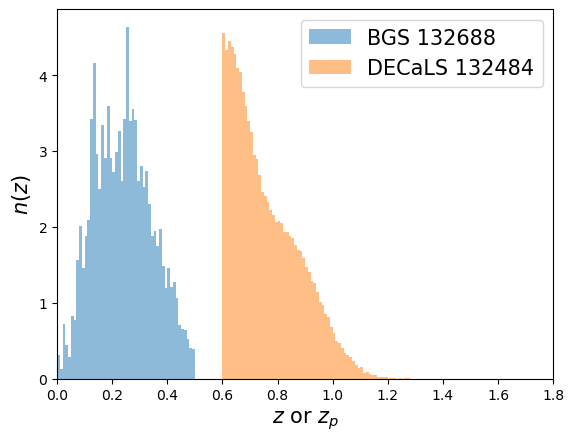

/home/ji/Research/anaconda3/envs/env1/lib/python3.9/site-packages/pyccl/tracers.py:110: CCLWarning: The number of samples in the n(z) (198) is smaller than the number of samples in the lensing kernel (256). Consider disabling spline integration for the lensing kernel by setting pyccl.gsl_params.LENSING_KERNEL_SPLINE_INTEGRATION = False
  warnings.warn(


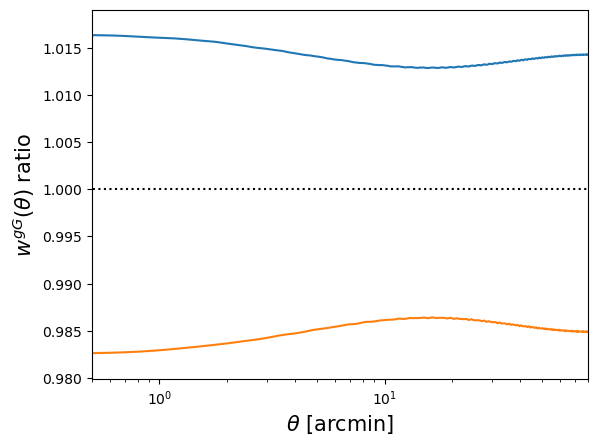

In [13]:
''' quantify impact from mean z for the source '''
filename = '../data/jk20_shear/BGS_ANYAlltiles_clustering.dat.fits'
nz_spec = get_nz_file(filename,'Z')
slt = (0>zarr)|(zarr>0.5)
nz_spec[slt] = 0
sumD = np.sum(nz_spec)
normD = sumD*(zarr[1]-zarr[0])
nz_spec /= normD
    
filename = '../data/jk20_shear/shear_in_footprint.fits'
nz_phot = get_nz_file(filename,'zp_mean')
slt = (0.6>zarr)|(zarr>1.5)
nz_phot[slt] = 0
sumE = np.sum(nz_phot)
normE = sumE*(zarr[1]-zarr[0])
nz_phot /= normE

plt.figure()
plt.bar(zarr,nz_spec,width=zarr[1]-zarr[0],alpha=0.5,label=Dtype[:3]+' '+str(int(sumD)))
plt.bar(zarr,nz_phot,width=zarr[1]-zarr[0],alpha=0.5,label=Elabel[0]+' '+str(int(sumE)))
plt.ylabel(r'$n(z)$',fontsize=15)
plt.legend(fontsize=15)
plt.xlim([0,1.8])
plt.xlabel(r'$z$ or $z_p$',fontsize=15)
plt.show()

dz_mean = 0.02
tracer_g1 = ccl.NumberCountsTracer(cosmo,has_rsd=False,dndz=(zarr,nz_spec),bias=(zarr,b_g)) # g
tracer_G0 = ccl.WeakLensingTracer(cosmo,dndz=(zarr,nz_phot)) # G
tracer_G1 = ccl.WeakLensingTracer(cosmo,dndz=(zarr+dz_mean,nz_phot)) # G
CgG0 = ccl.angular_cl(cosmo, tracer_g1, tracer_G0, ell) # C^{gG}
CgG1 = ccl.angular_cl(cosmo, tracer_g1, tracer_G1, ell) # C^{gG}
wgG0 = ccl.correlation(cosmo, ell, CgG0, theta/60., type='NG', method='FFTLog')
wgG1 = ccl.correlation(cosmo, ell, CgG1, theta/60., type='NG', method='FFTLog')
slt = zarr-dz_mean>0
tracer_G2 = ccl.WeakLensingTracer(cosmo,dndz=((zarr-dz_mean)[slt],nz_phot[slt])) # G
CgG2 = ccl.angular_cl(cosmo, tracer_g1, tracer_G2, ell) # C^{gG}
wgG2 = ccl.correlation(cosmo, ell, CgG2, theta/60., type='NG', method='FFTLog')

plt.figure()
plt.plot(theta,wgG1/wgG0)
plt.plot(theta,wgG2/wgG0)
plt.plot(theta,np.ones_like(theta),'k:')
plt.semilogx()
# plt.semilogy()
plt.xlabel(r'$\theta$ [arcmin]',fontsize=15)
plt.ylabel(r'$w^{gG}(\theta)$ ratio',fontsize=15)
plt.xlim([0.5,80])
plt.show()

In [14]:
print(theta[theta>51],wgG1[theta>51]/wgG0[theta>51])

[ 51.03971544  51.45041075  51.86441076  52.28174205  52.70243143
  53.12650592  53.55399276  53.98491941  54.41931355  54.85720308
  55.29861612  55.74358103  56.19212639  56.644281    57.10007391
  57.5595344   58.02269198  58.48957639  58.96021762  59.43464591
  59.91289173  60.39498579  60.88095906  61.37084275  61.86466834
  62.36246753  62.86427231  63.3701149   63.88002779  64.39404374
  64.91219576  65.43451714  65.96104142  66.49180242  67.02683423
  67.56617122  68.10984803  68.65789958  69.21036107  69.76726799
  70.32865611  70.89456148  71.46502046  72.04006969  72.61974609
  73.20408691  73.79312968  74.38691223  74.9854727   75.58884953
  76.19708149  76.81020763  77.42826735  78.05130034  78.67934661
  79.31244651  79.9506407   80.59397017  81.24247625  81.89620058
  82.55518516  83.21947232  83.88910471  84.56412537  85.24457763
  85.9305052   86.62195215  87.31896288  88.02158217  88.72985515
  89.4438273   90.16354448  90.88905293  91.62039925  92.3576304
  93.100793

/home/ji/Research/anaconda3/envs/env1/lib/python3.9/site-packages/pyccl/tracers.py:110: CCLWarning: The number of samples in the n(z) (199) is smaller than the number of samples in the lensing kernel (256). Consider disabling spline integration for the lensing kernel by setting pyccl.gsl_params.LENSING_KERNEL_SPLINE_INTEGRATION = False
  warnings.warn(


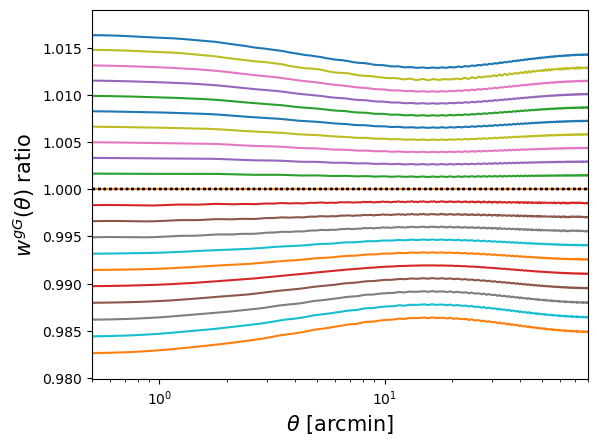

In [15]:
plt.figure()
sys_r = np.zeros((21,21))
sys_m = np.zeros(21)
sys_z = np.zeros(21)

for i in range(11):
    dz_mean = 0.002*i
    tracer_g1 = ccl.NumberCountsTracer(cosmo,has_rsd=False,dndz=(zarr,nz_spec),bias=(zarr,b_g)) # g
    tracer_G1 = ccl.WeakLensingTracer(cosmo,dndz=(zarr+dz_mean,nz_phot)) # G
    CgG1 = ccl.angular_cl(cosmo, tracer_g1, tracer_G1, ell) # C^{gG}
    wgG1 = ccl.correlation(cosmo, ell, CgG1, theta/60., type='NG', method='FFTLog')
    slt = zarr-dz_mean>0
    tracer_G2 = ccl.WeakLensingTracer(cosmo,dndz=((zarr-dz_mean)[slt],nz_phot[slt])) # G
    CgG2 = ccl.angular_cl(cosmo, tracer_g1, tracer_G2, ell) # C^{gG}
    wgG2 = ccl.correlation(cosmo, ell, CgG2, theta/60., type='NG', method='FFTLog')
    
    tck = interpolate.splrep(theta,wgG1/wgG,s=0)
    sys_z[10+i] = interpolate.splev(51.,tck,der=0)
    tck = interpolate.splrep(theta,wgG2/wgG,s=0)
    sys_z[10-i] = interpolate.splev(51.,tck,der=0)
    
    plt.plot(theta,wgG1/wgG)
    plt.plot(theta,wgG2/wgG)
    plt.plot(theta,np.ones_like(theta),'k:')
    
    sys_m[10+i] = 1+0.002*i
    sys_m[10-i] = 1-0.002*i
    
plt.semilogx()
# plt.semilogy()
plt.xlabel(r'$\theta$ [arcmin]',fontsize=15)
plt.ylabel(r'$w^{gG}(\theta)$ ratio',fontsize=15)
plt.xlim([0.5,80])
plt.show()

sys_M,sys_Z = np.meshgrid(sys_m,sys_z[::-1])
sys_r = sys_M * sys_Z



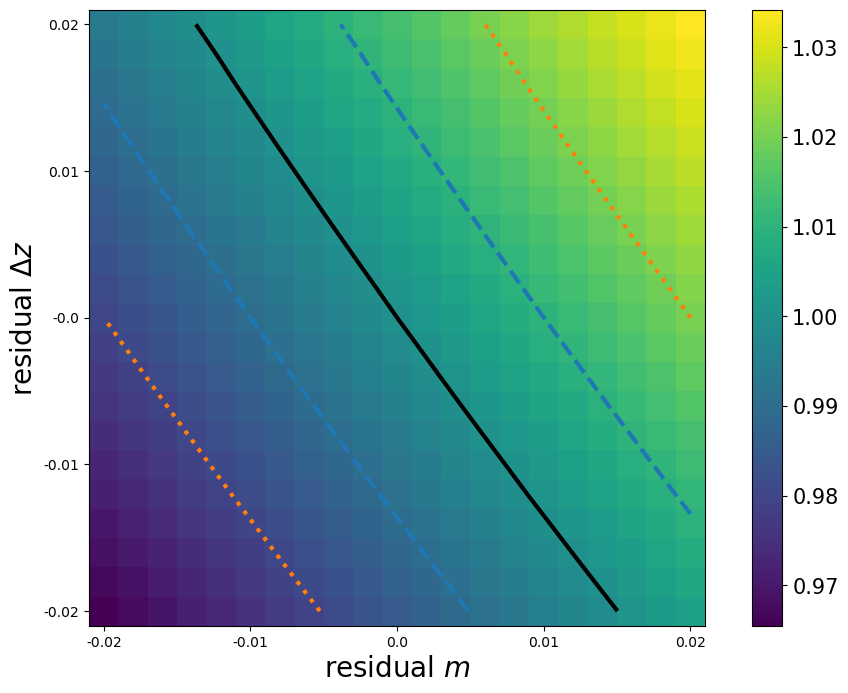

In [16]:
plt.figure(figsize=(12,8))
# r_CGG[r_CGG>1]=2
img = plt.imshow(sys_r)
plt.rcParams['font.size'] = 15
plt.colorbar(img)
plt.xticks([0,5,10,15,20],0.002*(np.array([0,5,10,15,20])-10))
plt.xlabel(r'residual $m$',fontsize=20)
plt.yticks([0,5,10,15,20],-0.002*(np.array([0,5,10,15,20])-10))
plt.ylabel(r'residual $\Delta z$',fontsize=20)
plt.contour(sys_r,[0.98,0.99,1,1.01,1.02],colors=(colorarray[1],colorarray[0],'k',colorarray[0],colorarray[1]),
            linewidths=[3,3,3,3,3], linestyles=[':','--','-','--',':'])

plt.savefig('../figure/sys_bias.png',bbox_inches='tight',dpi=300)

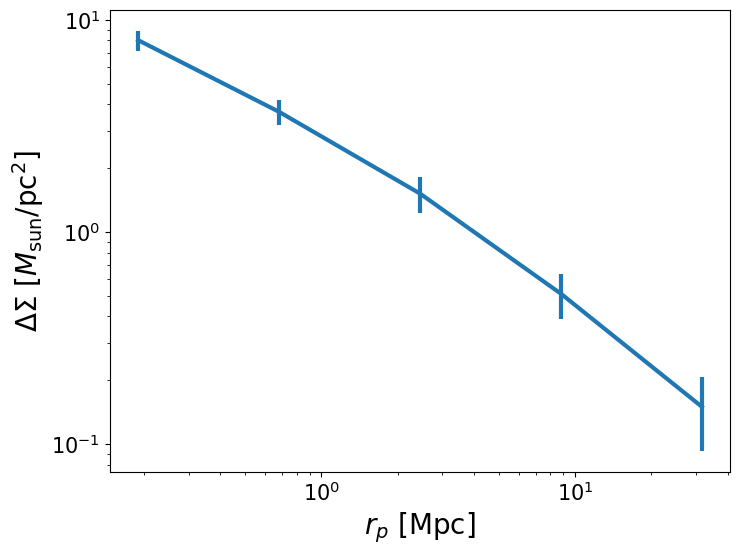

S/N = [9.05622584 7.42671729 5.24747189 4.14061082 2.64263412]


In [17]:
filename = '../data/jk50/test_dsigma_max50.npz'
f1=np.load(filename)
filename = '../data/jk50/test_dsigma_max60.npz'
f2=np.load(filename)

f = np.loadtxt('../data/dsigma_weiwei/ggl_cluster.cat',skiprows=5)
R = f[:,5]
SigR = f[:,1]
err = f[:,3]
f = np.loadtxt('../data/dsigma_weiwei/ggl_cluster_ran.cat',skiprows=5)
SigR_r = f[:,1]
f = np.loadtxt('../data/dsigma_weiwei/ggl_cluster_ran_calib.cat',skiprows=5)
calib = f[:,1]

f = np.loadtxt('../data/dsigma_huanyuan/ggl_decals_bgs.cat',skiprows=5)
R2 = f[:,0]
SigR2 = f[:,1]
err2 = f[:,2]
calib2 = f[:,3]

h = 1#0.67

plt.figure(figsize=(8,6))
# plt.errorbar(f1['rp'],f1['ds'],f1['ds_err'],label='Yao')
plt.errorbar(f2['rp'],f2['ds'],f2['ds_err'],label='Yao',linewidth=3,markersize=10)
# plt.errorbar(R/h,-(SigR-SigR_r)/calib*h,err,label='Xu')
# plt.errorbar(R2,SigR2/calib2,err2,label='Shan')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$r_p$ [Mpc]',fontsize=20)
plt.ylabel(r'$\Delta\Sigma$ $[M_{\rm sun}/{\rm pc}^2]$',fontsize=20)
# plt.legend(fontsize=15)
plt.savefig('../figure/ESD.png',bbox_inches='tight',dpi=300)
plt.show()

print('S/N =',f2['ds']/f2['ds_err'])

In [18]:
f2.files

['rp', 'ds', 'ds_err', 'ds_cov']

In [19]:
f=open('../data/dsigma_weiwei/ggl_cluster.cat', 'r'); lines=f.readlines(); f.close()
lines

['# Gal-gal lensing. Delta_Sigma(R) vs R, linear approximation\n',
 '# Resampling: jackknife (64 samples [=subvolumes]).\n',
 '# Coordinates: comoving\n',
 '# Cosmolgy: H0 = 67.4, Omega_M = 0.315, Omega_L = 0.684\n',
 '#  R(Mpc)  SigR(Msun/pc^2) err(weights) err(resampling) Nsources       <R>          e2\n',
 '   0.1861646   -6.9776097    0.8665422    0.8199889        96191254    0.2350234    0.6959011\n',
 '   0.6451950   -3.0426390    0.2517929    0.4547817       113456185    0.8147448    0.0580778\n',
 '   2.2360680   -1.3101065    0.0737467    0.3736134       271844459    2.8151802    0.2877743\n',
 '   7.7495949   -0.5696779    0.0232632    0.3836015      1747739730    9.5578467    0.1202825\n',
 '  26.8579588   -0.2929625    0.0099968    0.4749997      6835994577   30.4636018    0.1889996\n']

burn-in steps = 100, finished


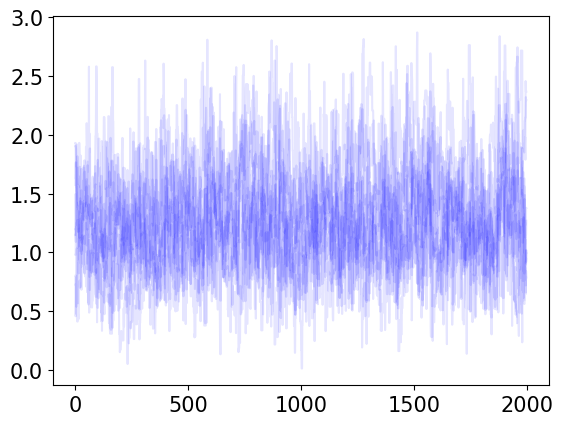

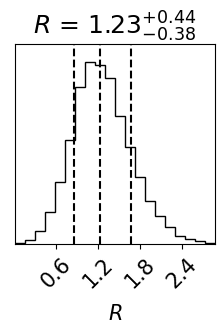

R =  [1.26142608]
\Delta R = [0.41646885]
burn-in steps = 100, finished


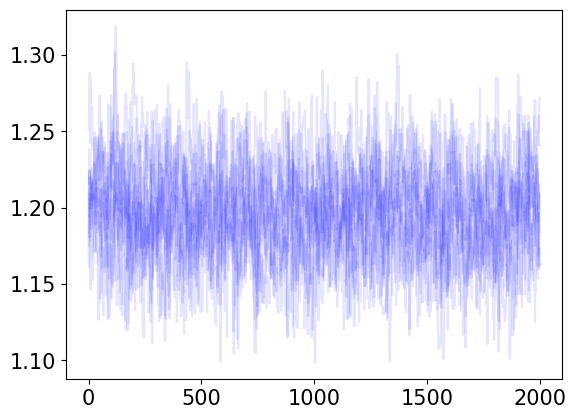

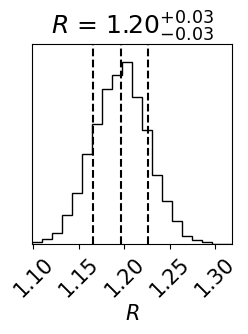

R =  [1.196049]
\Delta R = [0.03010381]
burn-in steps = 100, finished


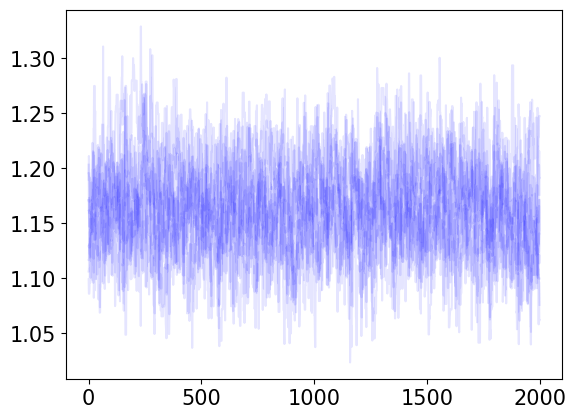

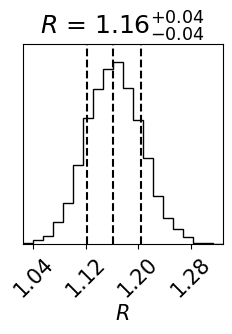

R =  [1.16293407]
\Delta R = [0.041616]


In [20]:
R_prior = [0,3]
jkN = 50

def lnprior_R(R):
    if (R_prior[0]<R and R<R_prior[1]):
        return 0.0
    return -np.inf


def lnL_R(R,d1,d2,C1,C2,C12,C21,Hartlap_correction=False): # my likelihood implementation directly from data
    lp = lnprior_R(R)
    if not np.isfinite(lp):
        return -np.inf

    vec = d1 - R*d2
    Q = C1 + R**2 * C2 - R*(C12+C21)
    Qinv = np.linalg.pinv(Q)
    if Hartlap_correction:
        Qinv *= ( jkN - len(d1) - 2 ) / (jkN-1)

    return lp - 0.5*np.dot( vec, np.dot(Qinv,vec) )

def fit_R(cut=[-1],Hartlap_correction=False,full_DESI=False): # fit my R
    samplelist = ['BGS_ANY0-0.5_0.9-1.5','BGS_ANY0-0.5_0.6-0.9']
    ''' --------- MCMC parameters '''
    nwalkers = 10
    ndim = 1
    nsteps = 2000

    for i,t1 in enumerate(samplelist):
        filename = '../data/jk'+str(jkN)+'/gG_'+t1+'/corr_gG_'+t1+'.npz'
        f = np.load(filename)
        if i==0:
            tmp = f['jk_gamma_t'][:,cut]
        elif i==1:
            tmp = np.hstack((tmp,f['jk_gamma_t'][:,cut]))

    cut = np.array(cut)
    d = np.average(tmp,axis=0)
    C = np.cov(tmp.T) * (jkN-1.)
    if full_DESI:
        C /= (9000/106)
    d1 = d[cut]
    C1 = C[cut][:,cut]
    C1inv = np.linalg.pinv(C1)
#     print(d1,C1)
    d2 = d[cut+len(cut)]
    C2 = C[cut+len(cut)][:,cut+len(cut)]
    C2inv = np.linalg.pinv(C2)
#     print(d2,C2)
    C12 = C[cut][:,cut+len(cut)]
    C21 = C[cut+len(cut)][:,cut]

    # ''' Hartlap correction for Cinv '''
    # Cinv *= ( jkN - len(cut)*2 - 2 ) / (jkN-1)

    p0 = np.array([[np.random.rand() for i in range(ndim)] for j in range(nwalkers)])
    for i in range(ndim):
        p0[:,i] = R_prior[0] + p0[:,i] * (R_prior[1]-R_prior[0])

    with Pool(processes=nwalkers) as pool:
    # with MPIPool() as pool:
    #     if not pool.is_master():
    #         pool.wait()
    #         sys.exit(0)

        sampler = emcee.EnsembleSampler(nwalkers, ndim, lnL_R, args=(d1,d2,C1,C2,C12,C21,Hartlap_correction),pool=pool)
        pos, prob, state = sampler.run_mcmc(p0, 100)
        sampler.reset()
        print('burn-in steps = 100, finished')
        sampler.run_mcmc(pos, nsteps)

#     dirname = '../data/jk'+str(jkN)+'/MCMC'
#     if not os.path.exists(dirname):
#         os.makedirs(dirname)
#     filename = dirname+'/BGS_R.npy'
#     np.save(filename,sampler.chain)

    plt.figure()
    for i in range(ndim):
        plt.subplot(ndim,1,i+1)
        for j in range(nwalkers):
            plt.plot(sampler.chain[j, :, i].reshape(nsteps),color='b',alpha=0.1)
    plt.show()
#     filename = '../figure/MCMCsteps_R.png'
#     plt.savefig(filename)

    stepcut = 0
    samples = sampler.chain[:,stepcut:,:].reshape((-1, ndim))

    lbl = [r'$R$']
    tr_val = [0.]
    fig = corner.corner(samples,labels=lbl,
                      truths=tr_val, quantiles=[0.16, 0.5, 0.84], show_titles=True, levels=(0.68,0.95,), plot_datapoints=False)
    plt.show()
#     filename = '../figure/MCMCresults_R.png'
#     plt.savefig(filename)

    tmp = np.mean(samples,axis=0)
    print('R = ', tmp)
    tmp = np.std(samples,axis=0)
    print('\Delta R =',tmp)
    
    return samples

# R_samples_noH_full_small = fit_R(cut=[0,1],Hartlap_correction=False)
R_samples_H = fit_R(cut=[0,1],Hartlap_correction=True,full_DESI=False)
R_samples_H_full = fit_R(cut=[0,1,2,3,4],Hartlap_correction=True,full_DESI=True)
R_samples_H_full_small = fit_R(cut=[0,1],Hartlap_correction=True,full_DESI=True)

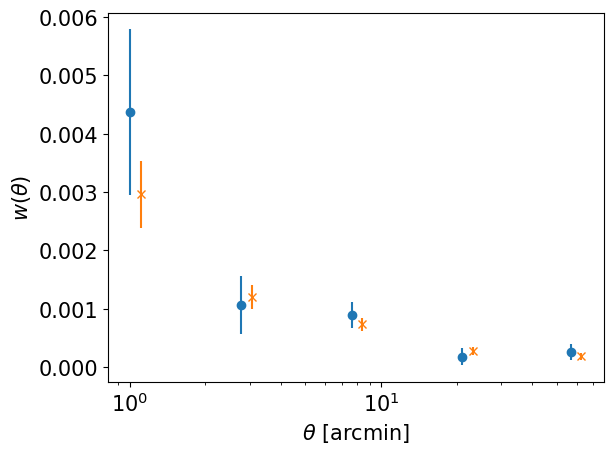

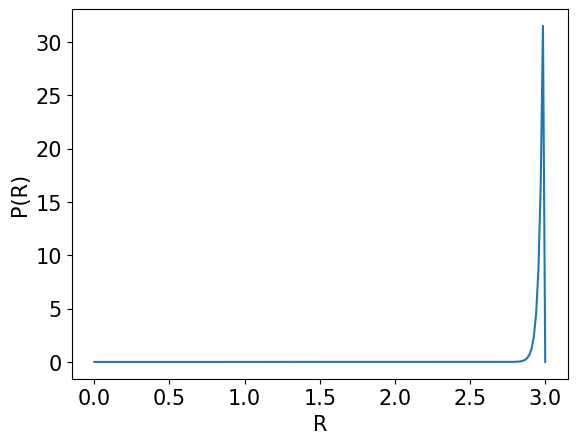

[2.98492462]


In [21]:
def ln_P_R(R,d1,d2,Cinv11,Cinv12,Cinv21,Cinv22): # implementation of Pengjie's ratio method
    lp = lnprior_R(R)
    if not np.isfinite(lp):
        return -np.inf

    vec = 1 * np.dot(Cinv11,d1) + 1 * np.dot(Cinv12,d2) + R * np.dot(Cinv21,d1) + R * np.dot(Cinv22,d2)
    Q = 1*Cinv11*1 + 1*Cinv12*R + R*Cinv21*1 + R*Cinv22*R
    Qinv = np.linalg.inv(Q)
#     Qinv = C1 - np.dot(C1,np.dot(np.linalg.pinv(C1+R**(-2)*C2),C1))

    return lp + np.log(np.linalg.det(Q)**0.5) * 0.5 * np.dot( vec, np.dot(Qinv,vec) )

def P_R(cut=[-1]):
    samplelist = ['BGS_ANY0-0.5_0.9-1.5','BGS_ANY0-0.5_0.6-0.9'] # note: the definition of shear-ratio is different for different methods, note the order of data
#     ''' --------- MCMC parameters '''
#     nwalkers = 10
#     ndim = 1
#     nsteps = 500

    for i,t1 in enumerate(samplelist):
        filename = '../data/jk'+str(jkN)+'/gG_'+t1+'/corr_gG_'+t1+'.npz'
        f = np.load(filename)
        if i==0:
            tmp = f['jk_gamma_t'][:,cut]
        elif i==1:
            tmp = np.hstack((tmp,f['jk_gamma_t'][:,cut]))

    cut1 = np.arange(len(cut))
    d = np.average(tmp,axis=0)
    C = np.cov(tmp.T) * (jkN-1.)
    Cinv = np.linalg.inv(C)
    d1 = d[cut1]
    d2 = d[cut1+len(cut1)]
    Cinv11 = Cinv[cut1][:,cut1]
    Cinv12 = Cinv[cut1][:,cut1+len(cut1)]
    Cinv21 = Cinv[cut1+len(cut1)][:,cut1]
    Cinv22 = Cinv[cut1+len(cut1)][:,cut1+len(cut1)]
    
    C1 = C[cut1][:,cut1]
    C2 = C[cut1+len(cut1)][:,cut1+len(cut1)]
    
    theta = f['r'][cut]
    plt.figure()
    plt.errorbar(theta,d1,np.sqrt(np.diag(C1)),fmt='o')
    plt.errorbar(theta*1.1,d2,np.sqrt(np.diag(C2)),fmt='x')
    plt.xscale('log')
    plt.xlabel(r'$\theta$ [arcmin]')
    plt.ylabel(r'$w(\theta)$')
    plt.show

    R = np.linspace(0,3,200)
    lnPR = [ln_P_R(x,d1,d2,Cinv11,Cinv12,Cinv21,Cinv22) for x in R]
    lnPR = lnPR - max(lnPR)
    norm = sum(np.exp(lnPR))*(R[1]-R[0])
    PR = np.exp(lnPR)/norm

    plt.figure()
    plt.plot(R,PR)
    plt.xlabel(r'R')
    plt.ylabel(r'P(R)')
#     plt.yscale('log')
    plt.show()
    
    slt = lnPR==max(lnPR)
    print(R[slt])
    
P_R(cut=[0,1,2,3,4])


In [22]:
tmp1 = np.array([1,2])
tmp2 = np.array([[1,2],[3,4]])
print(tmp1)
print(tmp2)
print(np.dot(tmp2,tmp1))
print(np.linalg.pinv(tmp2))

[1 2]
[[1 2]
 [3 4]]
[ 5 11]
[[-2.   1. ]
 [ 1.5 -0.5]]


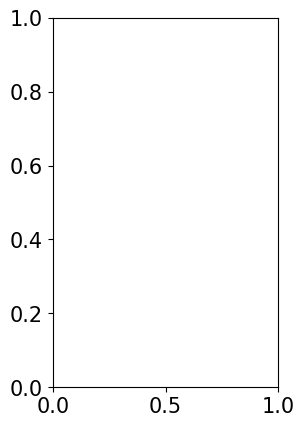

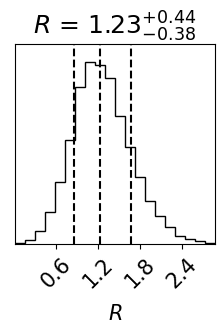

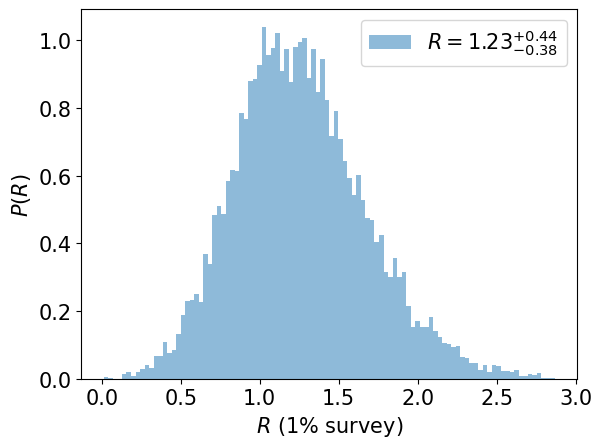

In [23]:
# plt.figure(figsize=(7,4))
lbl = [r'$R$']
tr_val = [0.]
ax = plt.subplot(1,2,1)
fig = corner.corner(R_samples_H, labels=lbl, 
                    truths=tr_val, quantiles=[0.16, 0.5, 0.84], show_titles=True, levels=(0.68,0.95,), plot_datapoints=False)
# ax = plt.subplot(1,2,2)
# fig = corner.corner(R_samples_noH_full, labels=lbl, 
#                     truths=tr_val, quantiles=[0.16, 0.5, 0.84], show_titles=True, levels=(0.68,0.95,), plot_datapoints=False)
# fig = corner.corner(R_samples_H, labels=r'$R$ H', fig=fig,
#                     truths=tr_val, quantiles=[0.16, 0.5, 0.84], show_titles=True, levels=(0.68,0.95,), plot_datapoints=False)
plt.show()

# plt.figure()
# plt.subplot(1,2,1)
# qt = np.quantile(R_samples_H,[0.16,0.5,0.84])
# lbl = r'$R=%.2f_{%.2f}^{+%.2f}$' %(qt[1],qt[0]-qt[1],qt[2]-qt[1])
# plt.hist(R_samples_H,bins=100,density=True,label=lbl,alpha=0.5)
# plt.legend(fontsize=12)
# plt.xlabel(r'$R$ (1%)')

# plt.subplot(1,2,2)
# qt = np.quantile(R_samples_H_full,[0.16,0.5,0.84])
# lbl = r'$R=%.2f_{%.2f}^{+%.2f}$' %(qt[1],qt[0]-qt[1],qt[2]-qt[1])
# plt.hist(R_samples_H_full,bins=100,density=True,label=lbl,alpha=0.5)

# qt = np.quantile(R_samples_H_full_small,[0.16,0.5,0.84])
# lbl = r'$R=%.2f_{%.2f}^{+%.2f}$' %(qt[1],qt[0]-qt[1],qt[2]-qt[1])
# plt.hist(R_samples_H_full_small,bins=100,density=True,label=lbl,alpha=0.5)
# plt.xlabel(r'$R$ (rescaled full)')

# plt.legend(fontsize=12)
# # plt.gca().yaxis.set_major_locator(plt.Nulllocator())
# plt.savefig('../figure/R.png',bbox_inches='tight',dpi=300)
# plt.show()

plt.figure()
# plt.subplot(1,2,1)
qt = np.quantile(R_samples_H,[0.16,0.5,0.84])
lbl = r'$R=%.2f_{%.2f}^{+%.2f}$' %(qt[1],qt[0]-qt[1],qt[2]-qt[1])
plt.hist(R_samples_H,bins=100,density=True,label=lbl,alpha=0.5)
plt.legend(fontsize=15)
plt.xlabel(r'$R$ (1% survey)')
plt.ylabel(r'$P(R)$')
plt.savefig('../figure/R.png',bbox_inches='tight',dpi=300)

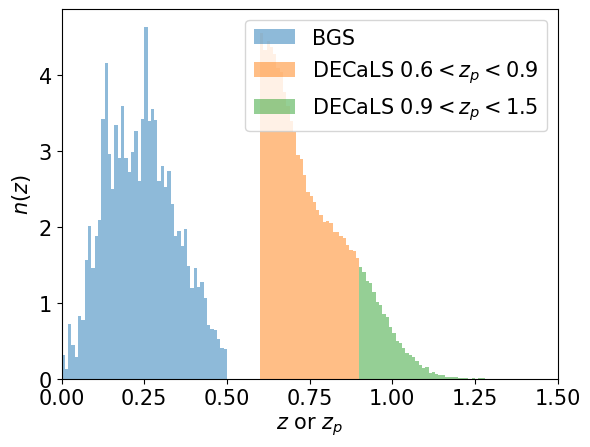

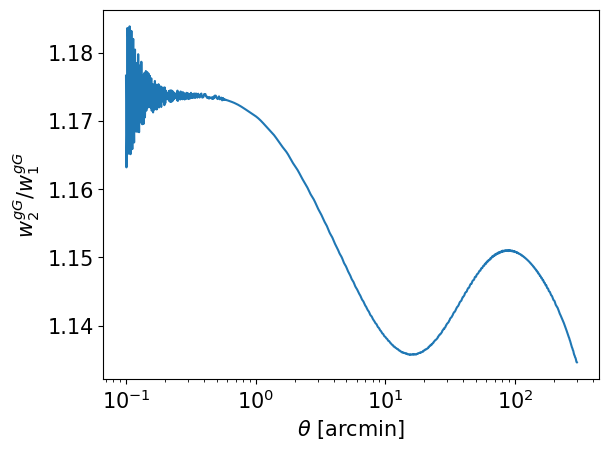

In [24]:
''' get theoretical shear ratio '''
''' --- BGS --- '''
# Dtype = 'BGS_ANY'
zD_range = [0,0.5]
# Etype = ['shear','kids','hsc']
# Ez = ['zp_mean','z_phot','z_phot']
zE_range1 = [0.6,0.9]
zE_range2 = [0.9,1.5]
# Elabel = ['DECaLS','KiDS','HSC']
bD = 1.34
use_mag = False

filename = '../data/jk50_shear/'+Dtype+'Alltiles_clustering.dat.fits'
nz_spec = get_nz_file(filename,'Z')
slt = (zD_range[0]>zarr)|(zarr>zD_range[1])
nz_spec[slt] = 0
sumD = np.sum(nz_spec)
normD = sumD*(zarr[1]-zarr[0])
nz_spec /= normD
    
filename = '../data/jk50_shear/shear_in_footprint.fits'
nz_phot = get_nz_file(filename,'zp_mean')
slt = (zE_range1[0]>zarr)|(zarr>zE_range2[1])
nz_phot[slt] = 0
sumE = np.sum(nz_phot)
normE = sumE*(zarr[1]-zarr[0])
nz_phot /= normE

nz_phot1 = np.zeros_like(nz_phot)
slt = (zE_range1[0]<=zarr)&(zarr<zE_range1[1])
nz_phot1[slt] = nz_phot[slt]

nz_phot2 = np.zeros_like(nz_phot)
slt = (zE_range2[0]<=zarr)&(zarr<zE_range2[1])
nz_phot2[slt] = nz_phot[slt]
    
plt.figure()
plt.bar(zarr,nz_spec,width=zarr[1]-zarr[0],alpha=0.5,label='BGS')
plt.bar(zarr,nz_phot1,width=zarr[1]-zarr[0],alpha=0.5,label=r'DECaLS $0.6<z_p<0.9$')
plt.bar(zarr,nz_phot2,width=zarr[1]-zarr[0],alpha=0.5,label=r'DECaLS $0.9<z_p<1.5$')
plt.ylabel(r'$n(z)$',fontsize=15)
plt.legend(fontsize=15)
plt.xlim([0,1.5])
plt.xlabel(r'$z$ or $z_p$',fontsize=15)
plt.show()

aarr = 1 / (1+zarr)
Darr = ccl.growth_factor(cosmo,aarr)
# Davg = np.average(Darr,weights=nz_spec)
# b_g = bD / Davg * np.ones_like(zarr)
b_g = bD / Darr

tracer_g = ccl.NumberCountsTracer(cosmo,has_rsd=False,dndz=(zarr,nz_spec),bias=(zarr,b_g)) # g
tracer_G1 = ccl.WeakLensingTracer(cosmo,dndz=(zarr,nz_phot1)) # G
tracer_G2 = ccl.WeakLensingTracer(cosmo,dndz=(zarr,nz_phot2)) # G
CgG1 = ccl.angular_cl(cosmo, tracer_g, tracer_G1, ell) # C^{gG}
wgG1 = ccl.correlation(cosmo, ell, CgG1, theta/60., type='NG', method='FFTLog')
CgG2 = ccl.angular_cl(cosmo, tracer_g, tracer_G2, ell) # C^{gG}
wgG2 = ccl.correlation(cosmo, ell, CgG2, theta/60., type='NG', method='FFTLog')

plt.figure()
plt.plot(theta,wgG2/wgG1)
plt.semilogx()
plt.xlabel(r'$\theta$ [arcmin]',fontsize=15)
plt.ylabel(r'$w^{gG}_2 / w^{gG}_1$',fontsize=15)
plt.show()
# str_zrange = str(zD_range[0])+'-'+str(zD_range[1])+'_'+str(zE_range[0])+'-'+str(zE_range[1])
# filename = '../data/jk50_shear/gG_'+Dtype+str_zrange+'/corr_gG_'+Dtype+str_zrange+'.npz'
# print(filename)
# f = np.load(filename)

# plt.figure()
# lbl = Dtype[:3]+' DECaLS'
# plt.errorbar(f['r'],f['gamma_t'],f['gamma_t_err'],fmt='o',color=colorarray[0],label=lbl)
# plt.plot(theta,wgG,color=colorarray[0])
# plt.plot(theta,np.zeros_like(theta),'k:')
# plt.xlim([0.5,80])
# plt.semilogx()
# plt.semilogy()
# plt.xlabel(r'$\theta$ [arcmin]',fontsize=15)
# plt.ylabel(r'$w^{gG}(\theta)$',fontsize=15)
# plt.legend(fontsize=15)
# plt.show()
# print('S/N =',f['gamma_t']/f['gamma_t_err'])

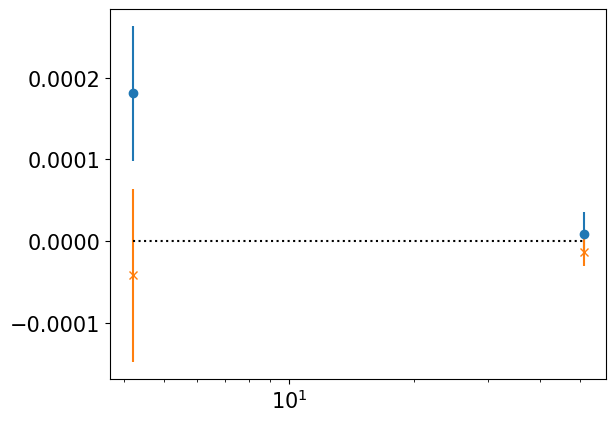

In [42]:
# f=np.load('../data/jk20_hsc/gG_ELG1-1.7_0.4-0.7/corr_gG_ELG1-1.7_0.4-0.7.npz')
# f=np.load('../data/jk20_kids/gG_ELG1-1.7_0.4-0.7/corr_gG_ELG1-1.7_0.4-0.7.npz')
f=np.load('../data/jk20_shear/gG_ELG1-1.7_0.4-0.7/corr_gG_ELG1-1.7_0.4-0.7.npz')

plt.figure()
plt.errorbar(f['r'],f['gamma_t'],f['gamma_t_err'],fmt='o')
plt.errorbar(f['r'],f['gamma_x'],f['gamma_x_err'],fmt='x')
plt.plot(f['r'],np.zeros_like(f['r']),'k:')
plt.semilogx()
plt.show()

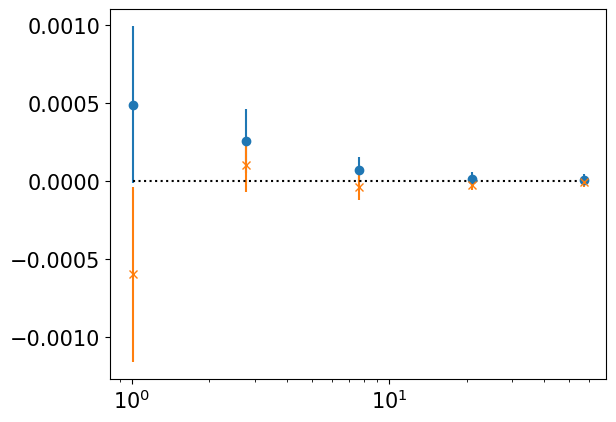

S/N = [0.97494868 1.25245903 0.91737611 0.34880597 0.31726479]


In [26]:
# f = np.load('../data/jk50_shear/gG_BGS_ANY0-0.5_0.6-1.5/corr_gG_BGS_ANY0-0.5_0.6-1.5.npz')
# f = np.load('../data/jk50_shear/gG_LRG0-0.6_0.7-1.5/corr_gG_LRG0-0.6_0.7-1.5.npz')
# f = np.load('../data/jk50_shear/gG_ELG0-0.7_0.8-1.5/corr_gG_ELG0-0.7_0.8-1.5.npz')
f = np.load('../data/jk50_shear/gG_ELG1-1.7_0.4-0.7/corr_gG_ELG1-1.7_0.4-0.7.npz')

plt.figure()
plt.errorbar(f['r'],f['gamma_t'],f['gamma_t_err'],fmt='o')
plt.errorbar(f['r'],f['gamma_x'],f['gamma_x_err'],fmt='x')
plt.plot(f['r'],np.zeros_like(f['r']),'k:')
plt.semilogx()
# plt.semilogy()
# plt.ylim([-0.0005,0.0005])
plt.show()
print('S/N =',f['gamma_t']/f['gamma_t_err'])

In [27]:
f = fio.FITS('../data/ELGAlltiles_full.dat.fits')[-1].read()
f

array([(39627733986184501,  529, 1419, 215.66006125, -2.14302565, 2015.5, 0.62598383, 0.5717973, -2.21462, 4611686018428829766, 0, 0, 0.1989161 , 63, 103400, 3, 34460401664, 3, 1, 221, 'QSO|MORE_MIDZQSO', '2021-04-13T18:07:44', '0.57.1', 9010, 318270, '2156m022', 3381, 'PSF', 0.04990136, 5.856021  , 6.5134296 , 9.669459  ,  837.4098 , 440.4444 , 58.26774 , 0.86267424, 0.90528524, 0.945862  , 1.6257942e-05, 2.3883982e-05, 3.3380860e-05, 0.01049328, 0.00946555, 0.01544175, 0.997169  , 0.9972589 , 0.9960487 , 4, 3, 2, 1871.8307 , 704.9228 , 66.051865, 1051.2617 , 406.4031 , 39.579597, 12.958737 , 24.797756 ,  2.8145862, 0.5965244, 0.9915789 , 0.9948199 , 0, 0, 0, 4.5563774 , 5.067885  , 7.5234876 , 4.5563774 , 5.067885  , 7.5234876 , 0, 0, 0, 'S', 1.24800776e+04, [ 5.01013503e-04,  1.96389936e-03,  2.26352057e-03, -3.78554082e-05,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00], 1.97932481e+00, 3.01674013e-04,      0,   7926, 'QSO', ''

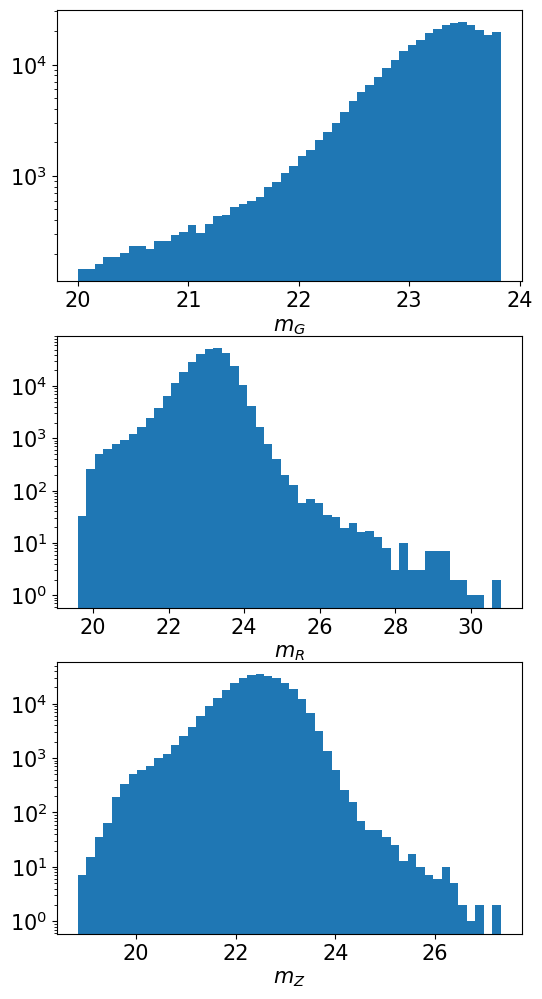

In [28]:
m_G = 22.5-2.5*np.log10(f['FLUX_G']/f['MW_TRANSMISSION_G'])
m_R = 22.5-2.5*np.log10(f['FLUX_R']/f['MW_TRANSMISSION_R'])
m_Z = 22.5-2.5*np.log10(f['FLUX_Z']/f['MW_TRANSMISSION_Z'])

plt.figure(figsize=(6,12))

plt.subplot(3,1,1)
plt.hist(m_G,bins=50)
plt.semilogy()
plt.xlabel(r'$m_G$',fontsize=15)

plt.subplot(3,1,2)
plt.hist(m_R,bins=50)
plt.semilogy()
plt.xlabel(r'$m_R$',fontsize=15)

plt.subplot(3,1,3)
plt.hist(m_Z,bins=50)
plt.semilogy()
plt.xlabel(r'$m_Z$',fontsize=15)

plt.show()

In [29]:
print('BGS')
print(np.array([9.1, 5.8])*np.sqrt(9000/106))
print(np.array([10.2, 3.9])*np.sqrt(456/55))
print(np.array([16.1, 4.3])*np.sqrt(733/48))

print('LRG')
print(np.array([3.5, 1.9])*np.sqrt(9000/106))
print(np.array([8.7, 2.2])*np.sqrt(456/55))
print(np.array([10.6, 2.4])*np.sqrt(733/48))

print('ELG')
print(np.array([-0.3, 1.4])*np.sqrt(9000/106))
print(np.array([-1.1, 1.4])*np.sqrt(456/55))
print(np.array([2.5, 2.6])*np.sqrt(733/48))

print(r'\Delta S_8')
print(0.1/np.sqrt(9000/106)*2)
print(0.14/np.sqrt(9000/106)*2)

print(r'\Delta S/N')
print(np.sqrt(9000/106))
print(np.sqrt(456/55))
print(np.sqrt(733/48))

BGS
[83.85128345 53.44367516]
[29.36981753 11.22963611]
[62.91544094 16.80350286]
LRG
[32.25049363 17.50741083]
[25.05072672  6.33466653]
[41.42258844  9.37869927]
ELG
[-2.76432803 12.90019745]
[-3.16733326  4.03115143]
[ 9.76947841 10.16025754]
\Delta S_8
0.021705094128132946
0.030387131779386123
\Delta S/N
9.214426752509267
2.8793938756115134
3.907791362564452


In [30]:
print(10.6/5.8)
print(4.2/5.7)
print(5.6/2.3)
print(6.1/2)
print(5.3/2)
print(np.array([5.2,5.8])/np.sqrt(9000/106))
print(6.1/0.63)
print(np.array([6,5.7])/np.sqrt(456/55))
print(6.1/2)
print(np.array([2.3,2.3])/np.sqrt(733/48))
print(6.1/0.6)

1.8275862068965518
0.7368421052631579
2.4347826086956523
3.05
2.65
[0.56433245 0.62944773]
9.682539682539682
[2.08377188 1.97958329]
3.05
[0.58856776 0.58856776]
10.166666666666666


mean-z = 0.3945264241592313
ELG DECaLS S/N = [-0.68014855  0.13718878]
[ 4.19706118 50.9911974 ] [-1.70986702  0.15451192] [2.51396111 1.1262723 ]
mean-z = 0.3943402328589909
ELG KiDS S/N = [-0.68714711 -0.33434705]
[ 4.20258906 51.12806535] [-0.72661136 -0.43475571] [1.05743201 1.30031265]
mean-z = 0.39838364779874225
ELG HSC S/N = [-0.20103143 -1.87370077]
[ 4.19301337 49.81027924] [-0.07725939 -1.14207785] [0.38431498 0.60953054]


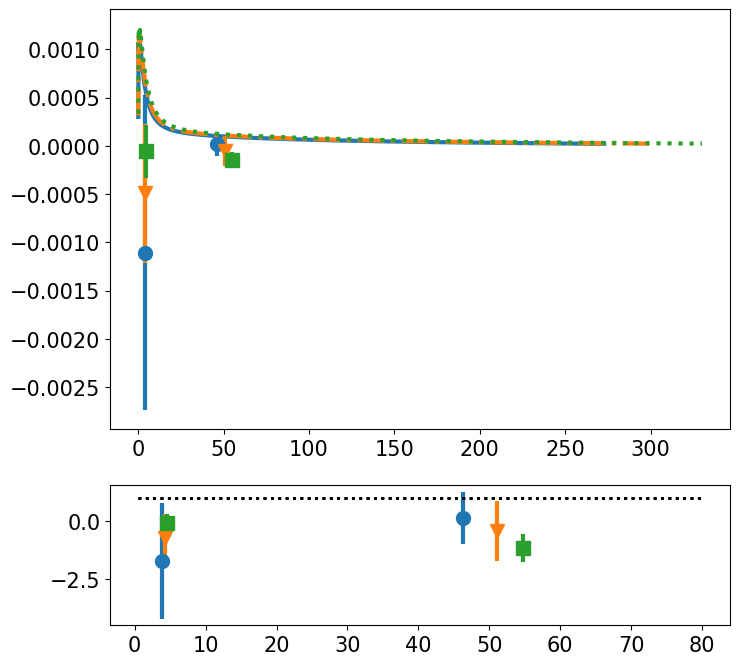

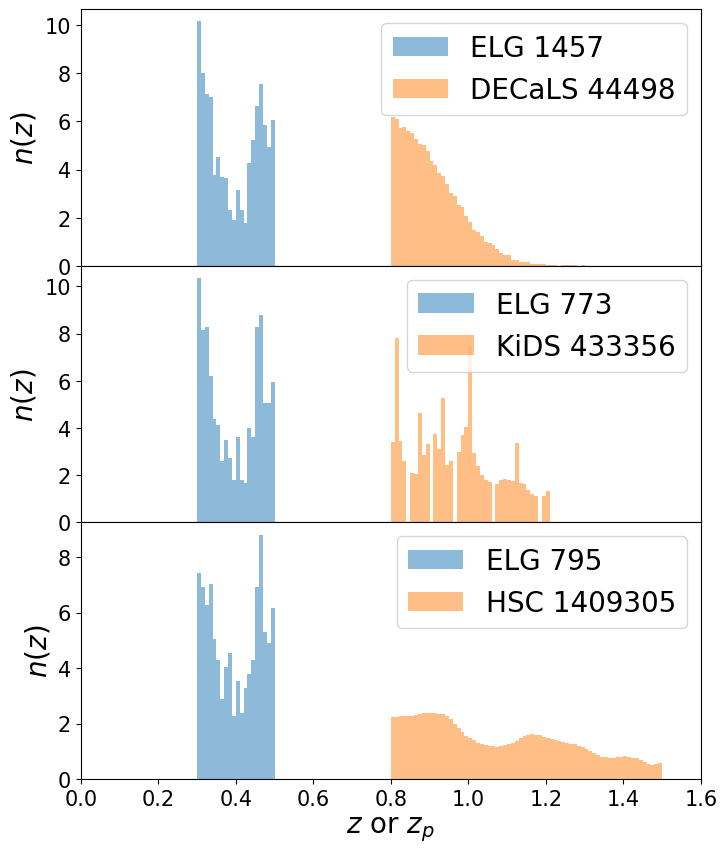

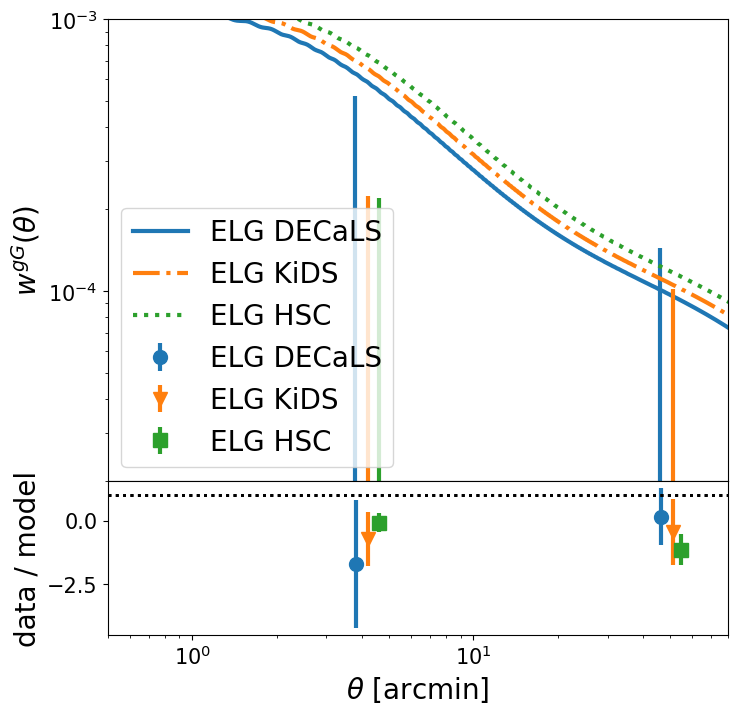

In [31]:
plt.rcParams.update({'font.size': 15})

zrange = np.linspace(0,2,201)
zarr = (zrange[1:]+zrange[:-1])/2
# print(zarr)

def get_nz_file(filename,field):
    f = fio.FITS(filename)
    Njk = len(f)
    nz_hist = np.zeros_like(zarr)
    for i in range(1,Njk):
        f = fio.FITS(filename)[i].read()
        nz_hist += np.histogram(f[field],bins=zrange)[0]
        
    return nz_hist

''' shared quantities for plots '''
Etype = ['shear','kids','hsc']
Ez = ['zp_mean','z_phot','z_phot']
Elabel = ['DECaLS','KiDS','HSC']
dotfmt = ['o','v','s']
linefmt = ['-','-.',':']

''' --- BGS --- '''
# Dtype = 'BGS_ANY'
# zD_range = [0.3,0.5]
# zE_range = [0.8,1.5]
# bD = 1.34
# use_mag = False
# corr_y_lim = [8e-5,2e-3]

# ''' --- LRG --- '''
# Dtype = 'LRG'
# zD_range = [0.3,0.5]
# zE_range = [0.8,1.5]
# bD = 1.7
# use_mag = False
# corr_y_lim = [6e-5,3e-3]

''' --- ELG --- '''
Dtype = 'ELG'
# zD_range = [0,0.25]
# zD_range = [0.25,0.7]
zD_range = [0.3,0.5]
zE_range = [0.8,1.5]
bD = 0.84
use_mag = False
corr_y_lim = [2e-5,1e-3]

''' --- ELG magnification --- '''
# Dtype = 'ELG'
# zD_range = [1,1.7]
# zE_range = [0.4,0.7]
# use_mag = True
# corr_y_lim = [3e-7,3e-4]

fig1 = plt.figure('nz',figsize=(8,10))
fig2 = plt.figure('w',figsize=(8,8))
gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1])
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])

for i in range(3):
    filename = '../data/jk20_'+Etype[i]+'/'+Dtype+'Alltiles_clustering.dat.fits'
    nz_spec = get_nz_file(filename,'Z')
    slt = (zD_range[0]>zarr)|(zarr>zD_range[1])
    nz_spec[slt] = 0
    sumD = np.sum(nz_spec)
    normD = sumD*(zarr[1]-zarr[0])
    nz_spec /= normD
    
    filename = '../data/jk20_'+Etype[i]+'/'+Etype[i]+'_in_footprint.fits'
    nz_phot = get_nz_file(filename,Ez[i])
    slt = (zE_range[0]>zarr)|(zarr>zE_range[1])
    nz_phot[slt] = 0
    sumE = np.sum(nz_phot)
    normE = sumE*(zarr[1]-zarr[0])
    nz_phot /= normE
    
    plt.figure(fig1)
    plt.subplot(3,1,i+1)
    plt.bar(zarr,nz_spec,width=zarr[1]-zarr[0],alpha=0.5,label=Dtype[:3]+' '+str(int(sumD)))
    print('mean-z =',np.average(zarr,weights=nz_spec))
    plt.bar(zarr,nz_phot,width=zarr[1]-zarr[0],alpha=0.5,label=Elabel[i]+' '+str(int(sumE)))
    plt.ylabel(r'$n(z)$',fontsize=20)
    plt.legend(fontsize=20,loc='upper right')
    plt.xlim([0,1.6])
    if i<2:
        plt.xticks([])
        
    if use_mag:
        tracer_K = ccl.WeakLensingTracer(cosmo,dndz=(zarr,nz_spec)) # K
        tracer_G = ccl.WeakLensingTracer(cosmo,dndz=(zarr,nz_phot)) # G
        CGG = ccl.angular_cl(cosmo, tracer_K, tracer_G, ell) # C^{KG}
        wKG = ccl.correlation(cosmo, ell, CGG, theta/60., type='NG', method='FFTLog')
        
        str_zrange = str(zD_range[0])+'-'+str(zD_range[1])+'_'+str(zE_range[0])+'-'+str(zE_range[1])
        filename = '../data/jk20_'+Etype[i]+'/gG_'+Dtype+str_zrange+'/corr_gG_'+Dtype+str_zrange+'.npz'
        f = np.load(filename)
        
        filename = '../data/jk20_'+Etype[i]+'/gG_'+Dtype+str_zrange+'_rN20/corr_gG_'+Dtype+str_zrange+'.npz'
        ft = np.load(filename)
        t_EDw = np.average(ft['sum_EDw'],axis=0)
        t_wKG = ccl.correlation(cosmo, ell, CGG, ft['r']/60., type='NG', method='FFTLog')
#         print(t_wgG)
        t_x = np.array([ np.average(ft['r'][:10],weights=t_EDw[:10]), np.average(ft['r'][-10:],weights=t_EDw[-10:]) ])
        t_y = np.array([ np.average(t_wKG[:10],weights=t_EDw[:10]), np.average(t_wKG[-10:],weights=t_EDw[-10:]) ])

        plt.figure(fig2)
        lbl = Dtype[:3]+' '+Elabel[i]
        ax0.errorbar(f['r']*1.1**(i-1),f['gamma_t'],f['gamma_t_err'],fmt=dotfmt[i],color=colorarray[i],label=lbl,linewidth=3,markersize=10)
        ax0.plot(theta*1.1**(i-1),wKG,linefmt[i],color=colorarray[i],label=lbl,linewidth=3)
        print(Dtype,Elabel[i],'S/N =',f['gamma_t']/f['gamma_t_err'])
        
        ax1.errorbar(f['r']*1.1**(i-1),f['gamma_t']/t_y,f['gamma_t_err']/t_y,fmt=dotfmt[i],color=colorarray[i],label=lbl,linewidth=3,markersize=10)
        ax1.plot([0.5,80],[1,1],'k:',linewidth=2)
        
    else:
        aarr = 1 / (1+zarr)
        Darr = ccl.growth_factor(cosmo,aarr)
#         Davg = np.average(Darr,weights=nz_spec)
#         b_g = bD / Davg * np.ones_like(zarr)
        b_g = bD / Darr

        tracer_g = ccl.NumberCountsTracer(cosmo,has_rsd=False,dndz=(zarr,nz_spec),bias=(zarr,b_g)) # g
        tracer_G = ccl.WeakLensingTracer(cosmo,dndz=(zarr,nz_phot)) # G
        CgG = ccl.angular_cl(cosmo, tracer_g, tracer_G, ell) # C^{gG}
        wgG = ccl.correlation(cosmo, ell, CgG, theta/60., type='NG', method='FFTLog')

        str_zrange = str(zD_range[0])+'-'+str(zD_range[1])+'_'+str(zE_range[0])+'-'+str(zE_range[1])
        filename = '../data/jk20_'+Etype[i]+'/gG_'+Dtype+str_zrange+'_rN2/corr_gG_'+Dtype+str_zrange+'.npz'
        f = np.load(filename)
        
        filename = '../data/jk20_'+Etype[i]+'/gG_'+Dtype+str_zrange+'_rN20/corr_gG_'+Dtype+str_zrange+'.npz'
        ft = np.load(filename)
        t_EDw = np.average(ft['sum_EDw'],axis=0)
        t_wgG = ccl.correlation(cosmo, ell, CgG, ft['r']/60., type='NG', method='FFTLog')
#         print(t_wgG)
        t_x = np.array([ np.average(ft['r'][:10],weights=t_EDw[:10]), np.average(ft['r'][-10:],weights=t_EDw[-10:]) ])
        t_y = np.array([ np.average(t_wgG[:10],weights=t_EDw[:10]), np.average(t_wgG[-10:],weights=t_EDw[-10:]) ])

        plt.figure(fig2)
        lbl = Dtype[:3]+' '+Elabel[i]
        ax0.errorbar(f['r']*(1+(i-1)*0.1),f['gamma_t'],f['gamma_t_err'],fmt=dotfmt[i],color=colorarray[i],label=lbl,linewidth=3,markersize=10)
        ax0.plot(theta*1.1**(i-1),wgG,linefmt[i],color=colorarray[i],label=lbl,linewidth=3)
#         plt.scatter(t_x,t_y,color=colorarray[i],marker='x',linewidth=5)
        print(Dtype,Elabel[i],'S/N =',f['gamma_t']/f['gamma_t_err'])
    
        ax1.errorbar(f['r']*1.1**(i-1),f['gamma_t']/t_y,f['gamma_t_err']/t_y,fmt=dotfmt[i],color=colorarray[i],label=lbl,linewidth=3,markersize=10)
        ax1.plot([0.5,80],[1,1],'k:',linewidth=2)
        
        print(f['r'],f['gamma_t']/t_y,f['gamma_t_err']/t_y)
    
plt.figure(fig1)
plt.subplots_adjust(wspace=0, hspace=0)
plt.xlabel(r'$z$ or $z_p$',fontsize=20)
# plt.xticks(np.linspace(0,1.6,9),np.linspace(0,1.6,9),fontsize=15)
# plt.yticks(np.linspace(0,6,7),np.linspace(0,6,7),fontsize=15)
# plt.xlim([0,1.6])
if use_mag:
    filename = '../figure/nz_'+Dtype+'_mag.png'
else:
    filename = '../figure/nz_'+Dtype+'.png'
# plt.savefig(filename,bbox_inches='tight',dpi=300)
plt.show()

plt.figure(fig2)
ax0.plot(theta,np.zeros_like(theta),'k:')
ax0.set_xlim([0.5,80])
ax0.set_ylim(corr_y_lim)
ax0.semilogx()
ax0.semilogy()
# ax0.set_xlabel(r'$\theta$ [arcmin]',fontsize=20)
if use_mag:
    ax0.set_ylabel(r'$w^{\kappa G}(\theta)$',fontsize=20)
else:
    ax0.set_ylabel(r'$w^{gG}(\theta)$',fontsize=20)
ax0.legend(fontsize=20,loc='lower left')
if use_mag:
    filename = '../figure/wgG_'+Dtype+'_mag.png'
else:
    filename = '../figure/wgG_'+Dtype+'.png'
    
ax1.set_xlim([0.5,80])
ax1.semilogx()
ax1.set_xlabel(r'$\theta$ [arcmin]',fontsize=20)
ax1.set_ylabel('data / model',fontsize=20)
plt.subplots_adjust(wspace=0, hspace=0)
# plt.savefig(filename,bbox_inches='tight',dpi=300)
plt.show()



[ 4.20218844 51.00154539] [ 0.99527353 -0.06780941] [0.28487677 0.42075212]
[ 4.19535036 51.2896734 ] [1.12074896 0.85164822] [0.18778132 0.44862365]
[ 4.1946764  50.14826179] [1.10733175 0.77817135] [0.11591574 0.44148467]
[ 4.19567504 51.01600026] [1.65647158 0.42384887] [0.51159498 0.5208735 ]
[ 4.18798487 51.40012399] [1.79727358 0.68768132] [0.32479633 0.34923211]
[ 4.18741083 50.09831498] [1.44081837 0.61363032] [0.12060167 0.25013847]
[ 4.19706118 50.9911974 ] [-1.70986702  0.15451192] [2.51396111 1.1262723 ]
[ 4.20258906 51.12806535] [-0.72661136 -0.43475571] [1.05743201 1.30031265]
[ 4.19301337 49.81027924] [-0.07725939 -1.14207785] [0.38431498 0.60953054]


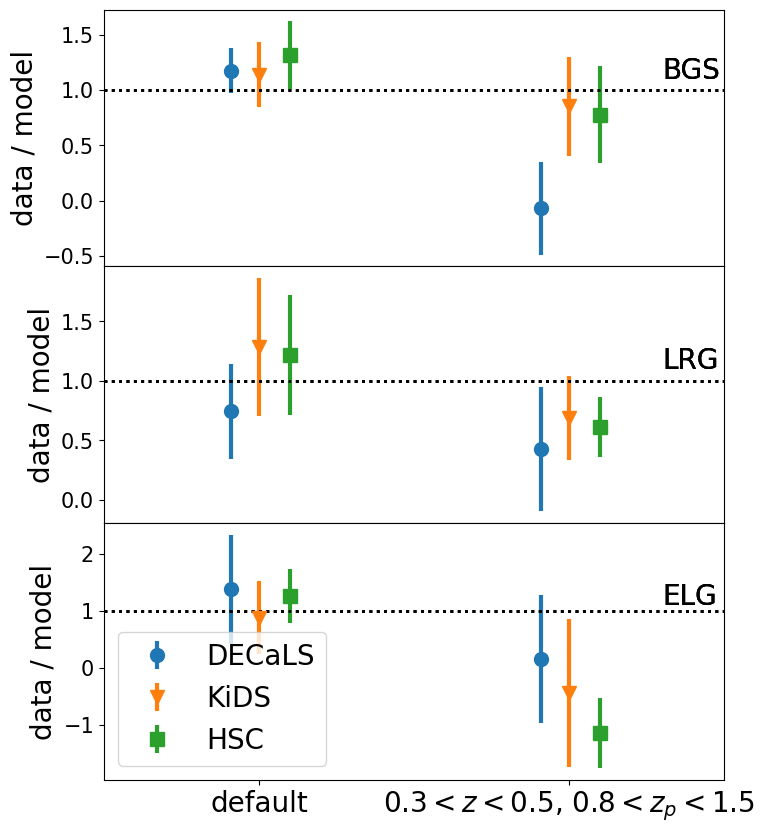

In [32]:
Dtype_list = ['BGS_ANY','LRG','ELG']
zD_range_list = [[0,0.5],[0,0.6],[0,0.7]]
zE_range_list = [[0.6,1.5],[0.7,1.5],[0.8,1.5]]
bD_list = np.array([1.34,1.7,0.84])

plt.figure(figsize=(8,10))

for j in range(3):
    Dtype = Dtype_list[j]
    bD = bD_list[j]
    
    for i in range(3):
        zD_range = zD_range_list[j]
        zE_range = zE_range_list[j]
        
        filename = '../data/jk20_'+Etype[i]+'/'+Dtype+'Alltiles_clustering.dat.fits'
        nz_spec = get_nz_file(filename,'Z')
        slt = (zD_range[0]>zarr)|(zarr>zD_range[1])
        nz_spec[slt] = 0
        sumD = np.sum(nz_spec)
        normD = sumD*(zarr[1]-zarr[0])
        nz_spec /= normD

        filename = '../data/jk20_'+Etype[i]+'/'+Etype[i]+'_in_footprint.fits'
        nz_phot = get_nz_file(filename,Ez[i])
        slt = (zE_range[0]>zarr)|(zarr>zE_range[1])
        nz_phot[slt] = 0
        sumE = np.sum(nz_phot)
        normE = sumE*(zarr[1]-zarr[0])
        nz_phot /= normE
        
        aarr = 1 / (1+zarr)
        Darr = ccl.growth_factor(cosmo,aarr)
#         Davg = np.average(Darr,weights=nz_spec)
#         b_g = bD / Davg * np.ones_like(zarr)
        b_g = bD / Darr

        tracer_g = ccl.NumberCountsTracer(cosmo,has_rsd=False,dndz=(zarr,nz_spec),bias=(zarr,b_g)) # g
        tracer_G = ccl.WeakLensingTracer(cosmo,dndz=(zarr,nz_phot)) # G
        CgG = ccl.angular_cl(cosmo, tracer_g, tracer_G, ell) # C^{gG}
        wgG = ccl.correlation(cosmo, ell, CgG, theta/60., type='NG', method='FFTLog')

        str_zrange = str(zD_range[0])+'-'+str(zD_range[1])+'_'+str(zE_range[0])+'-'+str(zE_range[1])
        filename = '../data/jk20_'+Etype[i]+'/gG_'+Dtype+str_zrange+'/corr_gG_'+Dtype+str_zrange+'.npz'
        f = np.load(filename)
        
        filename = '../data/jk20_'+Etype[i]+'/gG_'+Dtype+str_zrange+'_rN20/corr_gG_'+Dtype+str_zrange+'.npz'
        ft = np.load(filename)
        t_EDw = np.average(ft['sum_EDw'],axis=0)
        t_wgG = ccl.correlation(cosmo, ell, CgG, ft['r']/60., type='NG', method='FFTLog')
#         print(t_wgG)
        t_x = np.array([ np.average(ft['r'][:10],weights=t_EDw[:10]), np.average(ft['r'][-10:],weights=t_EDw[-10:]) ])
        t_y = np.array([ np.average(t_wgG[:10],weights=t_EDw[:10]), np.average(t_wgG[-10:],weights=t_EDw[-10:]) ])
        
        plt.subplot(3,1,j+1)
        plt.errorbar([1.1**(i-1)],f['gamma_t'][-1]/t_y[-1],f['gamma_t_err'][-1]/t_y[-1],fmt=dotfmt[i],color=colorarray[i],linewidth=3,markersize=10)

        ''' ---- selection --- '''
        zD_range = [0.3,0.5]
        zE_range = [0.8,1.5]
        
        filename = '../data/jk20_'+Etype[i]+'/'+Dtype+'Alltiles_clustering.dat.fits'
        nz_spec = get_nz_file(filename,'Z')
        slt = (zD_range[0]>zarr)|(zarr>zD_range[1])
        nz_spec[slt] = 0
        sumD = np.sum(nz_spec)
        normD = sumD*(zarr[1]-zarr[0])
        nz_spec /= normD

        filename = '../data/jk20_'+Etype[i]+'/'+Etype[i]+'_in_footprint.fits'
        nz_phot = get_nz_file(filename,Ez[i])
        slt = (zE_range[0]>zarr)|(zarr>zE_range[1])
        nz_phot[slt] = 0
        sumE = np.sum(nz_phot)
        normE = sumE*(zarr[1]-zarr[0])
        nz_phot /= normE
        
        aarr = 1 / (1+zarr)
        Darr = ccl.growth_factor(cosmo,aarr)
#         Davg = np.average(Darr,weights=nz_spec)
#         b_g = bD / Davg * np.ones_like(zarr)
        b_g = bD / Darr

        tracer_g = ccl.NumberCountsTracer(cosmo,has_rsd=False,dndz=(zarr,nz_spec),bias=(zarr,b_g)) # g
        tracer_G = ccl.WeakLensingTracer(cosmo,dndz=(zarr,nz_phot)) # G
        CgG = ccl.angular_cl(cosmo, tracer_g, tracer_G, ell) # C^{gG}
        wgG = ccl.correlation(cosmo, ell, CgG, theta/60., type='NG', method='FFTLog')

        str_zrange = str(zD_range[0])+'-'+str(zD_range[1])+'_'+str(zE_range[0])+'-'+str(zE_range[1])
        filename = '../data/jk20_'+Etype[i]+'/gG_'+Dtype+str_zrange+'_rN2/corr_gG_'+Dtype+str_zrange+'.npz'
        f = np.load(filename)
        
        filename = '../data/jk20_'+Etype[i]+'/gG_'+Dtype+str_zrange+'_rN20/corr_gG_'+Dtype+str_zrange+'.npz'
        ft = np.load(filename)
        t_EDw = np.average(ft['sum_EDw'],axis=0)
        t_wgG = ccl.correlation(cosmo, ell, CgG, ft['r']/60., type='NG', method='FFTLog')
#         print(t_wgG)
        t_x = np.array([ np.average(ft['r'][:10],weights=t_EDw[:10]), np.average(ft['r'][-10:],weights=t_EDw[-10:]) ])
        t_y = np.array([ np.average(t_wgG[:10],weights=t_EDw[:10]), np.average(t_wgG[-10:],weights=t_EDw[-10:]) ])

        plt.subplot(3,1,j+1)
        lbl = Elabel[i]
        plt.errorbar([1+1.1**(i-1)],f['gamma_t'][-1]/t_y[-1],f['gamma_t_err'][-1]/t_y[-1],fmt=dotfmt[i],color=colorarray[i],label=lbl,linewidth=3,markersize=10)
        plt.plot([0.5,2.5],[1,1],'k:',linewidth=2)
        plt.xlim([0.5,2.5])
        plt.ylabel('data / model',fontsize=20)
        plt.text(2.3,1.1,Dtype[:3],fontsize=20)
        plt.xticks([],[])
#         plt.semilogx()
        
        print(f['r'],f['gamma_t']/t_y,f['gamma_t_err']/t_y)
        
# plt.plot(theta,np.zeros_like(theta),'k:')


# plt.xlabel(r'$\theta$ [arcmin]',fontsize=20)
plt.xticks([1,2],['default',r'$0.3<z<0.5$, $0.8<z_p<1.5$'],fontsize=20)
plt.subplots_adjust(wspace=0, hspace=0)
plt.legend(fontsize=20)
filename = '../figure/low_signal.png'
plt.savefig(filename,bbox_inches='tight',dpi=300)
plt.show()
    

['r', 'gg', 'gg_err', 'jk_gg', 'Cov_gg', 'r_gg', 'jk_DD', 'jk_DR']


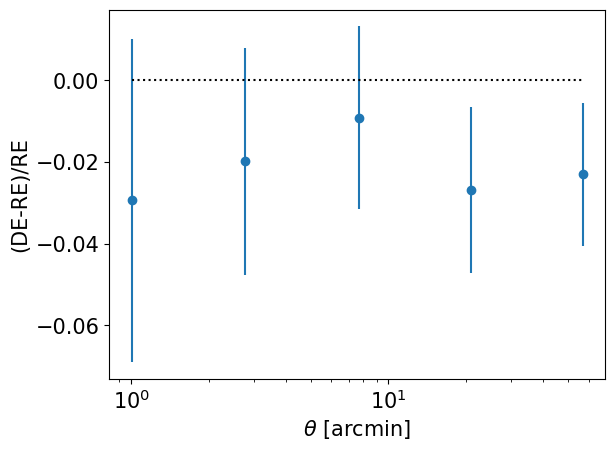

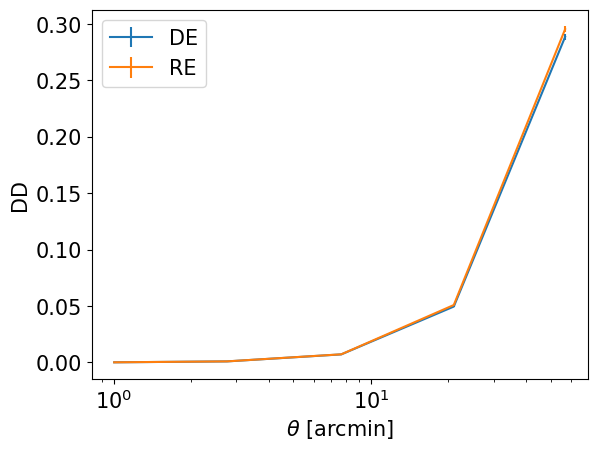

In [33]:
f = np.load('../data/jk50_shear/gG_ELG0.3-0.5_0.8-1.5_gg/corr_g_ELG0.3-0.5_0.8-1.5.npz')
# f = np.load('../data/jk50_shear/gG_ELG0.3-0.5_0.3-0.5_gg/corr_g_ELG0.3-0.5_0.3-0.5.npz')
# f = np.load('../data/jk50_shear/gG_BGS_ANY0-0.5_0-0.5_gg/corr_g_BGS_ANY0-0.5_0-0.5.npz')
# f = np.load('../data/jk50_shear/gG_BGS_ANY0.3-0.5_0.8-1.5_gg/corr_g_BGS_ANY0.3-0.5_0.8-1.5.npz')
print(f.files)
plt.figure()
plt.errorbar(f['r'],f['gg'],f['gg_err'],fmt='o')
plt.plot(f['r'],np.zeros_like(f['r']),'k:')
plt.semilogx()
plt.ylabel('(DE-RE)/RE')
plt.xlabel(r'$\theta$ [arcmin]')
plt.show()

plt.figure()
plt.errorbar(f['r'],np.mean(f['jk_DD'],axis=0),np.std(f['jk_DD'],axis=0),label='DE')
plt.errorbar(f['r'],np.mean(f['jk_DR'],axis=0),np.std(f['jk_DR'],axis=0),label='RE')
plt.semilogx()
plt.ylabel('DD')
plt.xlabel(r'$\theta$ [arcmin]')
plt.legend()
plt.show()

In [34]:
# Wavenumbers and scale factors
k_arr = np.geomspace(1E-4,1E2,512)
a_arr = np.linspace(0.1,1,100)

# We will use a mass definition with Delta = 200 times the matter density
hmd_200m = ccl.halos.MassDef200m()

# The Duffy 2008 concentration-mass relation
cM = ccl.halos.ConcentrationDuffy08(hmd_200m)

# The Tinker 2008 mass function
nM = ccl.halos.MassFuncTinker08(cosmo, mass_def=hmd_200m)

# The Tinker 2010 halo bias
bM = ccl.halos.HaloBiasTinker10(cosmo, mass_def=hmd_200m)

# The NFW profile to characterize the matter density around halos
pM = ccl.halos.profiles.HaloProfileNFW(cM)

hmc = ccl.halos.HMCalculator(cosmo, nM, bM, hmd_200m,log10M_min=8.0, log10M_max=16.0)

tk3d_1h = ccl.halos.halomod_Tk3D_1h(cosmo,
                          hmc,
                          prof1=pM,
                          prof2=pM,
                          prof3=pM,
                          prof4=pM,
                         prof12_2pt=None,prof34_2pt=None,
                         normprof1=True,normprof2=True,normprof3=True,normprof4=True,
                         lk_arr=np.log(k_arr),
                         a_arr=a_arr)
tk3d_SSC = ccl.halos.halomod_Tk3D_SSC(cosmo,
                          hmc,
                          prof1=pM,
                          prof2=pM,
                          prof3=pM,
                          prof4=pM,
                         prof12_2pt=None,prof34_2pt=None,
                         normprof1=True,normprof2=True,normprof3=True,normprof4=True,
                         lk_arr=np.log(k_arr),
                         a_arr=a_arr)



3.944671717171717 0.35953030303030303 0.0013332376230512238
37


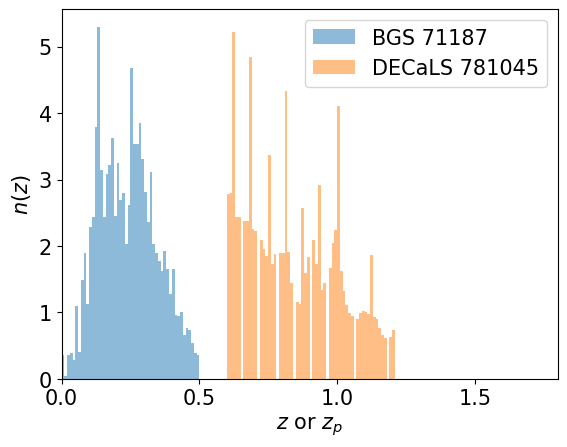

C(ell) Gaussian S/N = 20.249716009809482


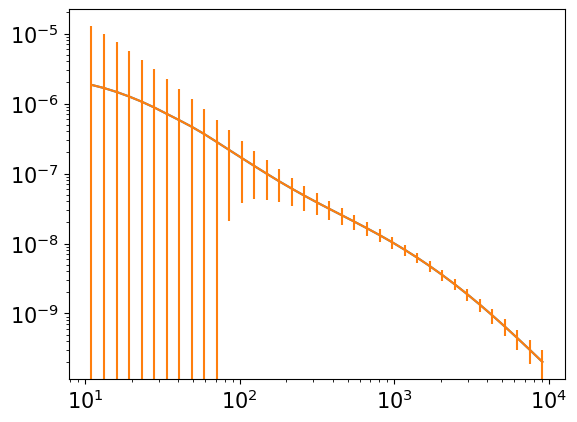

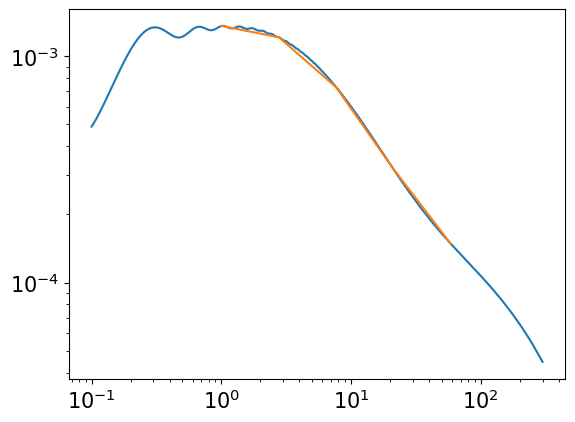

In [35]:
# ng_G = 132484/90/60**2
# ng_g = 132688/90/60**2
# f_sky = 90/(4*np.pi*(180/np.pi)**2)
# e_rms = 0.27
# print(f_sky)

ng_G = 781045/55/60**2
ng_g = 71187/55/60**2
f_sky = 55/(4*np.pi*(180/np.pi)**2)
e_rms = 0.27
print(ng_G,ng_g,f_sky)

ell_min = 10
ell_max = 10000
Dell = 0.2
n_ell = np.int32(np.log(ell_max/ell_min)/np.log(1+Dell))
print(n_ell)

ell = np.logspace(np.log10(ell_min),np.log10(ell_max),n_ell+1)
ell = np.sqrt(ell[1:]*ell[:-1])

Cov_G = np.zeros((n_ell,n_ell))
Cov_cNG = np.zeros_like(Cov_G)
Cov_SSC = np.zeros_like(Cov_G)

''' --- BGS --- '''
Dtype = 'BGS_ANY'
zD_range = [0,0.5]
Etype = ['shear','kids','hsc']
Ez = ['zp_mean','z_phot','z_phot']
zE_range = [0.6,1.5]
Elabel = ['DECaLS','KiDS','HSC']
bD = 1.34
use_mag = False

# ''' --- LRG --- '''
# Dtype = 'LRG'
# zD_range = [0,0.6]
# Etype = ['shear','kids','hsc']
# Ez = ['zp_mean','z_phot','z_phot']
# zE_range = [0.7,1.5]
# Elabel = ['DECaLS','KiDS','HSC']
# bD = 1.7
# use_mag = False

filename = '../data/jk20_kids/'+Dtype+'Alltiles_clustering.dat.fits'
nz_spec = get_nz_file(filename,'Z')
slt = (zD_range[0]>zarr)|(zarr>zD_range[1])
nz_spec[slt] = 0
sumD = np.sum(nz_spec)
normD = sumD*(zarr[1]-zarr[0])
nz_spec /= normD
    
filename = '../data/jk20_kids/kids_in_footprint.fits'
nz_phot = get_nz_file(filename,'z_phot')
slt = (zE_range[0]>zarr)|(zarr>zE_range[1])
nz_phot[slt] = 0
sumE = np.sum(nz_phot)
normE = sumE*(zarr[1]-zarr[0])
nz_phot /= normE
    
plt.figure()
plt.bar(zarr,nz_spec,width=zarr[1]-zarr[0],alpha=0.5,label=Dtype[:3]+' '+str(int(sumD)))
plt.bar(zarr,nz_phot,width=zarr[1]-zarr[0],alpha=0.5,label=Elabel[0]+' '+str(int(sumE)))
plt.ylabel(r'$n(z)$',fontsize=15)
plt.legend(fontsize=15)
plt.xlim([0,1.8])
plt.xlabel(r'$z$ or $z_p$',fontsize=15)
plt.show()

aarr = 1 / (1+zarr)
Darr = ccl.growth_factor(cosmo,aarr)
# Davg = np.average(Darr,weights=nz_spec)
# b_g = bD / Davg * np.ones_like(zarr)
b_g = bD / Darr

tracer_g = ccl.NumberCountsTracer(cosmo,has_rsd=False,dndz=(zarr,nz_spec),bias=(zarr,b_g)) # g
tracer_G = ccl.WeakLensingTracer(cosmo,dndz=(zarr,nz_phot)) # G
CgG = ccl.angular_cl(cosmo, tracer_g, tracer_G, ell) # C^{gG}
Cgg = ccl.angular_cl(cosmo, tracer_g, tracer_g, ell) # C^{gg}
CGG = ccl.angular_cl(cosmo, tracer_G, tracer_G, ell) # C^{GG}

wgG = ccl.correlation(cosmo, ell, CgG, theta/60., type='NG', method='FFTLog')
theta_b = np.logspace(np.log10(0.5),np.log10(80),6)
# theta_i = np.sqrt(theta_b[1:]*theta_b[:-1])
theta_i = 2*(theta_b[1:]**2 + theta_b[1:]*theta_b[:-1] + theta_b[:-1]**2) / 3 / (theta_b[1:]+theta_b[:-1])
wgG_i = ccl.correlation(cosmo, ell, CgG, theta_i/60., type='NG', method='FFTLog')

NGG = e_rms**2 / (ng_G*(180*60/np.pi)**2)
Ngg = 1 / (ng_g*(180*60/np.pi)**2)
Cov_G = np.diag( 1/(2*ell+1)/(Dell*ell)/f_sky * ( CgG**2 + (Cgg+Ngg)*(CGG+NGG) ) )
print('C(ell) Gaussian S/N =',np.sqrt(np.dot(CgG,np.dot(np.linalg.inv(Cov_G),CgG))))

plt.figure()
plt.loglog(ell,CgG)
plt.errorbar(ell,CgG,np.sqrt(np.diag(Cov_G)))
plt.show()

plt.figure()
plt.loglog(theta,wgG)
plt.loglog(theta_i,wgG_i)
plt.show()

In [36]:
Cov_cNG = ccl.angular_cl_cov_cNG(cosmo=cosmo,
                       cltracer1=tracer_g, cltracer2=tracer_G,
                       cltracer3=tracer_g, cltracer4=tracer_G,
                       ell=ell,
                       tkka=tk3d_1h,
                       fsky=f_sky )
Cov_SSC = ccl.angular_cl_cov_SSC(cosmo=cosmo,
                       cltracer1=tracer_g, cltracer2=tracer_G,
                       cltracer3=tracer_g, cltracer4=tracer_G,
                       ell=ell,
                       tkka=tk3d_SSC,
                       fsky=f_sky )


C(ell) non-Gaussian S/N = 7.535148137085931


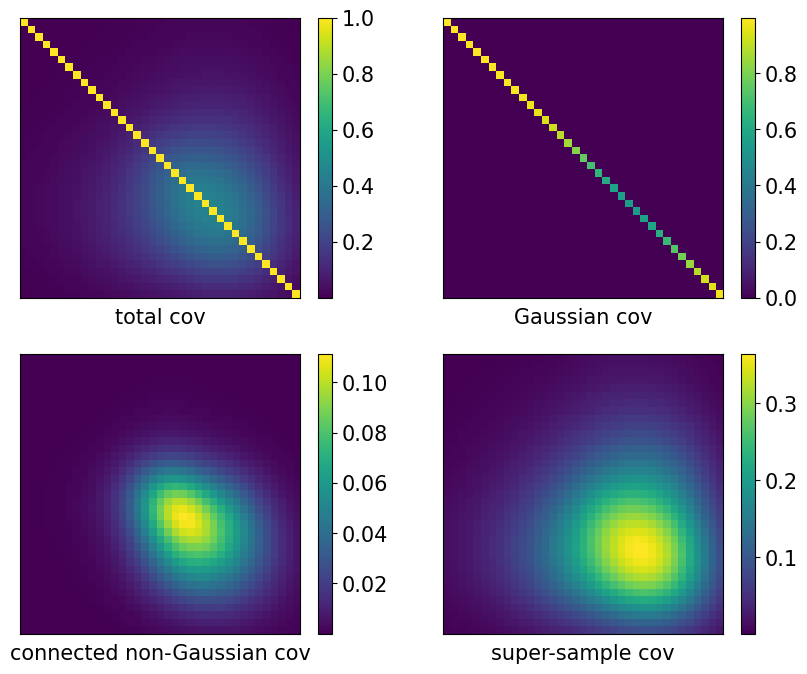

In [37]:
def get_r_norm(cov1,cov2):
    r = np.zeros_like(cov1)
    for i in range(len(r)):
        for j in range(len(r)):
            r[i,j] = cov1[i,j]/np.sqrt(cov2[i,i]*cov2[j,j])
    return r

Cov_tot = Cov_G+Cov_cNG+Cov_SSC

plt.figure(figsize=(10,8))
r_tot = get_r_norm(Cov_tot,Cov_tot)
plt.subplot(2,2,1)
img = plt.imshow(r_tot)
plt.rcParams['font.size'] = 15
plt.colorbar(img)
plt.xticks([],[])
plt.yticks([],[])
plt.xlabel('total cov')

# plt.figure(figsize=(10,8))
r_G = get_r_norm(Cov_G,Cov_tot)
plt.subplot(2,2,2)
img = plt.imshow(r_G)
plt.rcParams['font.size'] = 15
plt.colorbar(img)
plt.xticks([],[])
plt.yticks([],[])
plt.xlabel('Gaussian cov')

# plt.figure(figsize=(12,8))
plt.subplot(2,2,3)
r_NG = get_r_norm(Cov_cNG,Cov_tot)
img = plt.imshow(r_NG)
plt.rcParams['font.size'] = 15
plt.colorbar(img)
plt.xticks([],[])
plt.yticks([],[])
plt.xlabel('connected non-Gaussian cov')

# plt.figure(figsize=(12,8))
plt.subplot(2,2,4)
r_SSC = get_r_norm(Cov_SSC,Cov_tot)
img = plt.imshow(r_SSC)
plt.rcParams['font.size'] = 15
plt.colorbar(img)
plt.xticks([],[])
plt.yticks([],[])
plt.xlabel('super-sample cov')

# plt.savefig('../figure/KiDS_X_BGS_cov.png',bbox_inches='tight',dpi=300)

print('C(ell) non-Gaussian S/N =',np.sqrt(np.dot(CgG,np.dot(np.linalg.inv(Cov_G+Cov_cNG+Cov_SSC),CgG))))

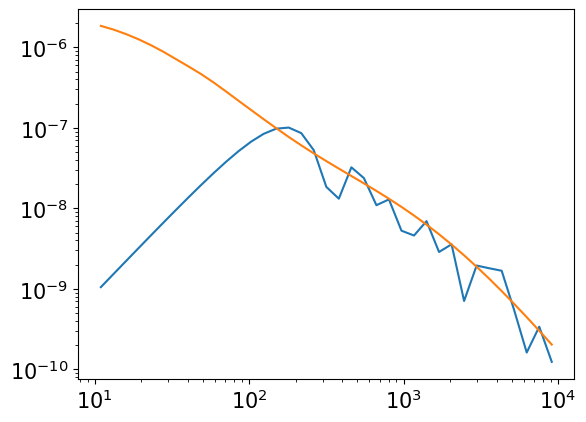

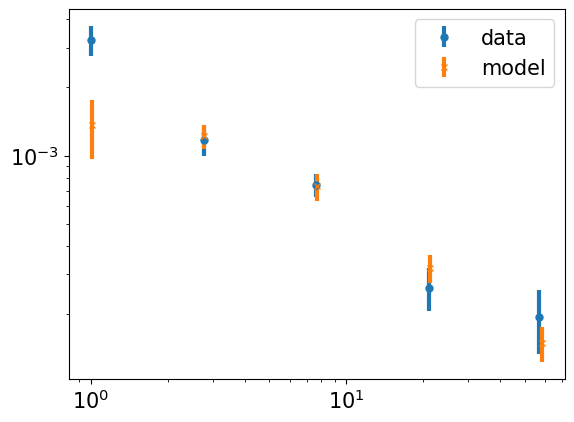

w(theta) non-Gaussian S/N = 10.204531995236099


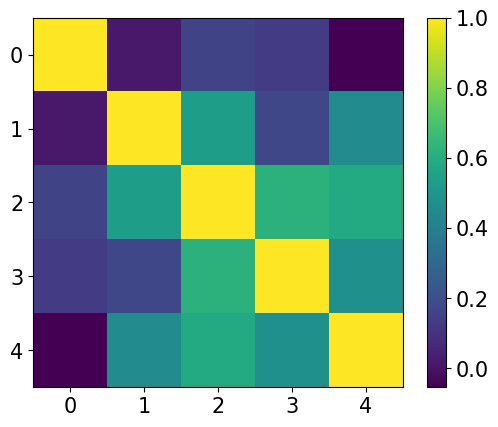

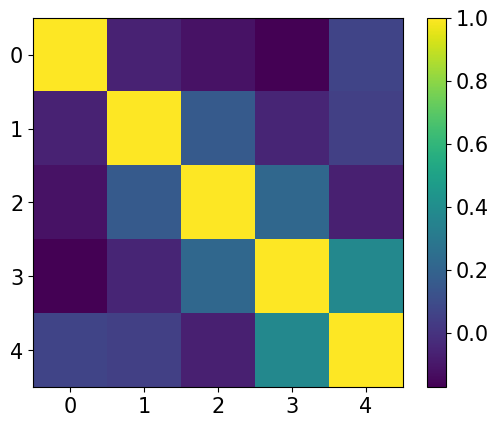

In [43]:
from scipy.special import jv

def K2tool(x):
    return -x*jv(1,x)-2*jv(0,x)

def K2(theta_l,theta_u,ell):
    ''' K2 transfers theta to ell '''
#     return 2/(theta_u**2-theta_l**2)/ell**2 * ( K2tool(ell*theta_u) - K2tool(ell*theta_l) )
    return 2*np.pi/ell**2 * ( K2tool(ell*theta_u) - K2tool(ell*theta_l) )

K2_m = np.zeros((len(ell),len(theta_i)))
for i,tmp_ell in enumerate(ell):
    for j,tmp_theta in enumerate(theta_i):
        K2_m[i,j] = K2(theta_b[j]/60/180*np.pi,theta_b[j+1]/60/180*np.pi,tmp_ell)
        
C_test = np.dot(K2_m,wgG_i.T)

plt.figure()
plt.loglog(ell,C_test)
plt.loglog(ell,CgG)
plt.show()

Cov = Cov_G+Cov_cNG+Cov_SSC
Cov_w = np.linalg.inv( np.dot( K2_m.T, np.dot(np.linalg.inv(Cov),K2_m) ) )

plt.figure()
f = np.load('../data/jk50_shear/gG_BGS_ANY0-0.5_0.6-1.5/corr_gG_BGS_ANY0-0.5_0.6-1.5.npz')
plt.errorbar(f['r'],f['gamma_t'],f['gamma_t_err'],fmt='o',color=colorarray[0],label='data',linewidth=3,markersize=5)
plt.errorbar(theta_i,wgG_i,np.sqrt(np.diag(Cov_w)),fmt='x',color=colorarray[1],label='model',linewidth=3,markersize=5)
plt.semilogx()
plt.semilogy()
plt.legend()
plt.show()

Cov_jk = np.cov(f['jk_gamma_t'].T)*np.sqrt(50-1)

cut = np.array([1,2,3,4])
print('w(theta) non-Gaussian S/N =',
      np.sqrt(np.dot(wgG_i[cut],np.dot(np.linalg.inv(Cov_w[cut][:,cut]),wgG_i[cut]))))

plt.figure()
r_w = get_r_norm(Cov_w,Cov_w)
img = plt.imshow(r_w)
plt.rcParams['font.size'] = 15
plt.colorbar(img)

plt.figure()
r_jk = get_r_norm(Cov_jk,Cov_jk)
img = plt.imshow(r_jk)
plt.rcParams['font.size'] = 15
plt.colorbar(img)


In [39]:
ccl.__version__

'2.5.1'